`Copyright (c) Meta Platforms, Inc. and affiliates. This source code is licensed under the CC-BY-NC license found in the LICENSE file in the root directory of this source tree.`

# Carbon Explorer
Carbon Explorer uses U.S. EIA's hourly renewable energy generation data and simulated hourly datacenter power profile data to evaluate solutions to make datacenters operate on renewable energy 24/7.

Three solutions are analyzed in this notebook:
* Capacity sizing with a mix of solar and wind power
* Battery storage
* Carbon aware workload scheduling

The notebook contains the following parts in order::

1. **Data Preparation and Configuration**
2. **Renewable Investment Analysis**
3. **Battery Deployment Analysis**
4. **Carbon Aware Scheduling Anaylsis**
5. **Combined Embodied and Operational Footprint Analysis**

# 1. Data Preparation and Configuration

## 1.1. Download EIA's U.S. Electric System Operating Data

In [2]:
from src.download_and_process import *
import os

# SET the data path (<EIA_bulk_data_dir>) for location of EIA data
EIA_bulk_data_dir = os.getcwd() + "/EBA"

In [6]:
# Download EIA's U.S. Electric System Operating Data
# SKIP this step, if EIA data is already downloaded

downloadAndExtract(EIA_bulk_data_dir)

100% [......................................................................] 439637137 / 439637137

## 1.2. Prepare EIA energy source data for processing

**`prepareEIAData():`** Reads the EIA bulk json file and converts it into a data frame.

Populates `ba_list`, which is a list of all balancing authorities in the US.

Populates `eba_json`, which will be used later for `extractBARange` function.

In [3]:
eba_json, ba_list, ta_list = prepareEIAData(EIA_bulk_data_dir)

print("List of all balancing authorities: \t", ba_list)

EIA data prep done!
List of all balancing authorities: 	 ['CAR', 'DUK', 'EPE', 'FLA', 'FPC', 'FPL', 'WAUW', 'SRP', 'FMPP', 'PACW', 'PSCO', 'PSEI', 'SCEG', 'SOCO', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'NY', 'TEN', 'TEX', 'SWPP', 'TEPC', 'TIDC', 'TPWR', 'US48', 'WACM', 'WALC', 'CENT', 'NW', 'SC', 'SE', 'SW', 'AVA', 'CAL', 'CISO', 'CPLE', 'CPLW', 'DOPD', 'ERCO', 'GCPD', 'IPCO', 'GVL', 'HST', 'NYIS', 'PACE', 'PGE', 'PJM', 'PNM', 'SCL', 'SEC', 'SPA', 'TAL', 'TEC', 'TVA', 'AECI', 'LDWP', 'MIDW', 'NE', 'NWMT', 'JEA', 'ISNE', 'MISO', 'NEVP', 'LGEE', 'MIDA', 'IID', 'GWA', 'SEPA', 'GRID', 'GRIF', 'HGMA', 'DEAA', 'WWA', 'YAD', 'AVRN', 'GLHB', 'AEC', 'EEI', 'NSB', 'OVEC', 'GRMA']


## 1.3. Configure Carbon Explorer

In [61]:
# SET the values below in order to customize this notebook
#
# Folder containing the EIA's extracted bulk data
EIA_bulk_data_dir = os.getcwd() + "/EBA"

# <dc_ba_map>: map of datacenters to be analyzed
# Add/remove datacenters to/from this map which contains
# datacenter locations (state) and corresponding balancing authority (BA)
# Find which the map of BA's in the U.S. here:
# https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48
dc_ba_map = {
    "OR": "BPAT",
    "NC": "DUK",
    "UT": "PACE",
}

# <dc_power_map>: map of average DC power capacity in MW
dc_power_map = {
    "OR": 70,
    "NC": 50,
    "UT": 20,
}

# <ba_ppa_map>: map of renewable [wind, solar] investment amounts (in MW) you want to make for each grid (BA)
ba_ppa_map = {
    "BPAT": [500, 0],   # 500 MW wind farm, no solar farm
    "DUK": [0, 410],    # no wind farm, 410 MW solar farm
    "PACE": [239, 694], # 239 MW wind, 694 MW solar farm
}

# Default data range to analyze: [START_DATE, END_DATE]
# EIA's bulk data starts from July 2018 and gets updated daily
# Any date range between mid 2018 to downlaod date can be selected
# Note that longer time frames increases evaluation time.
START_DATE = "2021-05-01"
END_DATE = "2021-05-15"

# Embodied Carbon Footprint Numbers
# numbers are taken from the corresponding links below
# Battery
# https://www.forbes.com/sites/rrapier/2020/02/16/estimating-the-carbon-footprint-of-utility-scale-battery-storage/?sh=1dc64eb97adb
embodied_battery_footprint = 74 #tons of CO2 per MWh batttery capacity, when manufacturing is fully renewable
#embodied_battery_footprint = 134 #tons of CO2 per MWh batttery capacity, when manufacturing is not renewable
cycles = 3000
battery_lifetime = cycles/365  # years
# Servers
# https://www.hpe.com/psnow/doc/a50002430enw?jumpid=in_lit-psnow-red
dc_footprint_surcharge = 1.15 # addtional footprint for non-server components
embodied_server_footprint = (744.5/120)*dc_footprint_surcharge # tons per MW
server_lifetime = 4 # years
# Solar and wind farms
# https://www.nrel.gov/analysis/life-cycle-assessment.html
# https://www.nrel.gov/analysis/assets/images/lca_harm_ng_fig_2.jpg
# https://yaleclimateconnections.org/2021/06/whats-the-carbon-footprint-of-a-wind-turbine/
# These numbers are derived from a life cycle analysis and accounts for its manufacturing cost and the expected amount of energy generated.
embodied_solar_farm_footprint = 55 # kg of CO2 per MWh
embodied_wind_farm_footprint = 12 # kg of CO2 per MWh

## 1.4. Simulate Hourly Datacenter Power Load
**`extractDCRange(region, start_day, end_day, swing_percentage=5):`**  Returns a dataframe of DC power for the given date range set as index. Hourly DC power is simulated as a sine wave with the given fluctuation/swing percentage.

**`region`**: state of the DC, must be an item in the `dc_power_map`

**`START_DATE`**: i.e. "2021-01-01"

**`END_DATE`**: i.e. "2021-02-01"

**`swing_percentage`**: (optional), daily fluctuation in power in terms of percentage of the minimum power. Defaults to 5% daily power swings.

In [5]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

def extractDCRange(region, start_day, end_day, swing_percentage=5):
    idx = pd.date_range(start_day, end_day, freq = "H")
    x = np.linspace(0, len(idx)-1, len(idx))
    # generate a sin wave with amplitude depending on the swing_percentage
    avg_pow = (np.sin(x/4)*dc_power_map[region]*swing_percentage/100)/2 + dc_power_map[region]
    # shift the sin wave to make peak power around noon time
    avg_pow = np.roll(avg_pow, 6)
    # create a dataframe with index set as the data index
    pf = pd.DataFrame(avg_pow, index=idx, columns=['avg_dc_power_mw'])
    pf.index.name = 'index'
    return pf

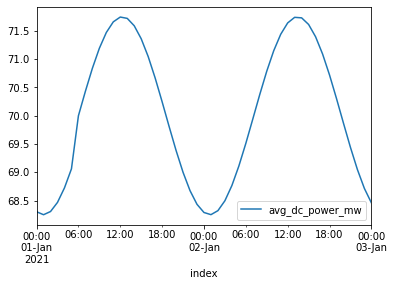

In [6]:
dc_region_pow = extractDCRange('OR', "2021-01-01", "2021-01-03")
dc_region_pow.plot()

## 1.5. Retrieving a dataframe of energy generation for a BA
**`extractBARange(ba_idx, start_day, end_day):`** returns a dataframe containing energy types and the amount generated in the grid, indexed by hourly timesteps

`ba_idx`: id of the balancing authority, i.e. CISO

`start_day`: starting date of the time frame, i.e. "2021-01-01"

`end_day`: ending date of the time frame, i.e. "2021-01-01"

In [7]:
ba_idx = dc_ba_map['OR']
db = extractBARange(ba_idx, START_DATE, END_DATE)
db

,WND,SUN,WAT,OIL,NG,COL,NUC,OTH
2021-05-01 00:00:00+00:00,2184,58,5260,0,256,0,964,209
2021-05-01 01:00:00+00:00,2132,32,5511,0,257,0,963,206
2021-05-01 02:00:00+00:00,1834,14,7217,0,257,0,960,210
2021-05-01 03:00:00+00:00,1541,3,7383,0,258,0,961,208
2021-05-01 04:00:00+00:00,1517,-1,7120,0,259,0,961,210
...,...,...,...,...,...,...,...,...
2021-05-14 20:00:00+00:00,45,72,8323,0,5,0,0,202
2021-05-14 21:00:00+00:00,54,61,8254,0,5,0,0,199
2021-05-14 22:00:00+00:00,80,70,8429,0,5,0,0,195
2021-05-14 23:00:00+00:00,112,62,8470,0,5,0,0,197


## 1.6. Calculate carbon intensity of the local grid and combine with DC power load

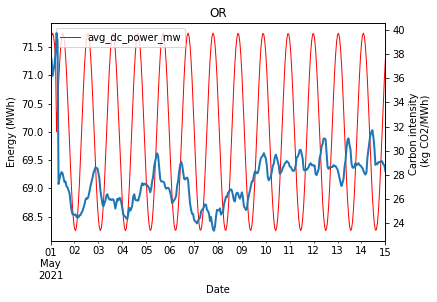

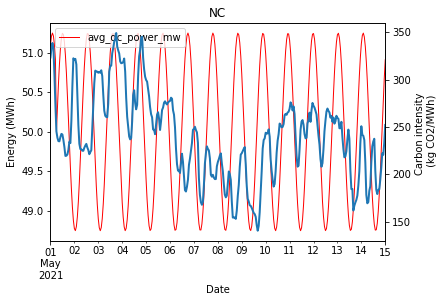

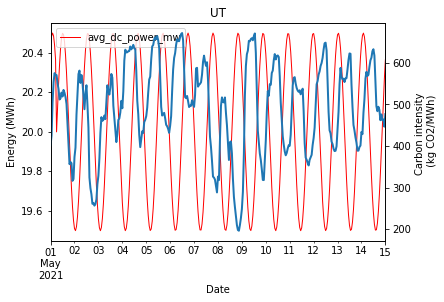

In [8]:
#Plot DC power usage and the carbon intensity of the corresponding grid

# Simulate each datacenter in our map
for dc in dc_ba_map:
    d = extractDCRange(dc, START_DATE, END_DATE)
    ax = d.plot(kind='line', color='red', lw=1)

    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    carbon_intensity = calculateAVGCarbonIntensity(db)
    carbon_intensity.plot(kind='line', stacked=False, title=dc, ax = ax, secondary_y=True, lw=2)
    
    ax.legend(loc='upper left')
    ax.set_xlabel("Date")
    ax.set_ylabel("Energy (MWh)")
    ax.right_ax.set_ylabel('Carbon intensity \n (kg CO2/MWh)')
    plt.show()

# 2. Renewable Investment Analysis

Calculates hourly renewable coverage using given wind and solar investment amounts.

Prints out % renewable coverage ratios for each datacenter given the investments in `ba_ppa_map` per local grid.

Renewable Investment Amount --  SUN:  0 WND:  500
Renewable coverage ratio: 74.02 %


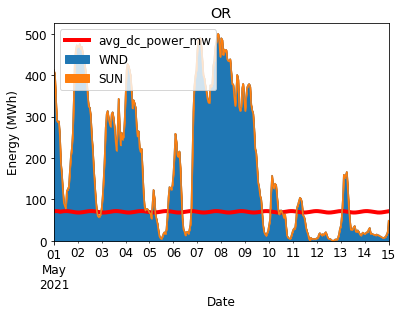

Renewable Investment Amount --  SUN:  410 WND:  0
Renewable coverage ratio: 50.43 %


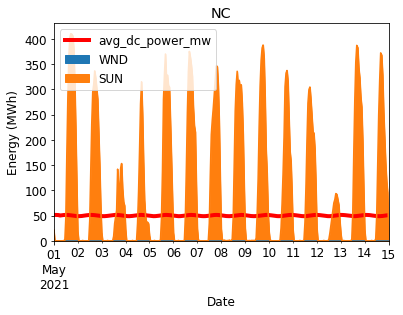

Renewable Investment Amount --  SUN:  694 WND:  239
Renewable coverage ratio: 99.61 %


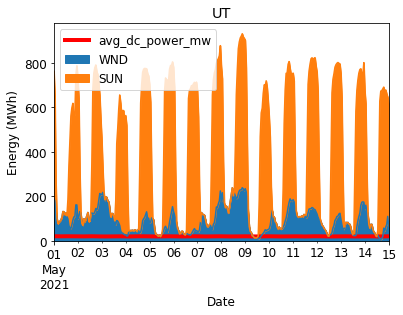

In [55]:
import src.utils as utils
START_DATE = '2021-05-01'
END_DATE = '2021-05-15'

# Simulate each datacenter in our map
for dc in dc_ba_map:
    d = extractDCRange(dc, START_DATE, END_DATE)
    ax = d.plot(kind='line', color='red', lw=4)
    d = d['avg_dc_power_mw']
    
    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    db[db < 0] = 0
    wnd_db = db['WND'].fillna(0)
    sun_db = db['SUN'].fillna(0)
    max_wnd_cap = wnd_db.max()
    max_sun_cap = sun_db.max()
    SUN_PPA_MW = ba_ppa_map[dc_ba_map[dc]][1]
    WND_PPA_MW = ba_ppa_map[dc_ba_map[dc]][0]
    print("Renewable Investment Amount --  SUN: ", SUN_PPA_MW, "WND: ", WND_PPA_MW)
    # Project the renewable generation amount from your ren. investments
    # based on the maximum generation in the grid during the corresponding data range
    if(max_wnd_cap != 0):
        wnd_db = wnd_db/max_wnd_cap*WND_PPA_MW
    if(max_sun_cap != 0):
        sun_db = sun_db/max_sun_cap*SUN_PPA_MW
    projected_db = pd.concat([wnd_db, sun_db], axis=1)
    
    # Calculate renewable coverage
    coverage = utils.calculate_coverage((wnd_db + sun_db), d)
    print("Renewable coverage ratio: {:0.2f} %".format(coverage))

    projected_db.plot(kind='area', stacked=True, title=dc, ax = ax, xlabel="Date", ylabel="Energy (MWh)")

    ax.legend(loc='upper left')
    plt.show()

## 2.1. Renewable Coverage for Different Wind and Solar Investment Amounts

 **Renewable Coverage** entails the percentage of hours that consume carbon-free energy during datacenter's operation. Next cell calculates hourly **renewable coverage** for a sweep of wind and solar investments amounts.
The range of the sweep is determined by `max_wind_range` and `max_sol_range` parameters which specifies the MW deployment amounts.

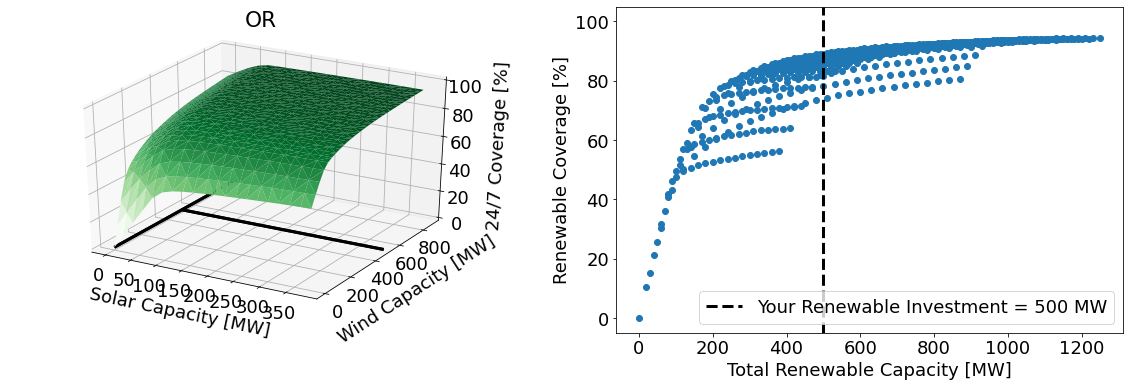

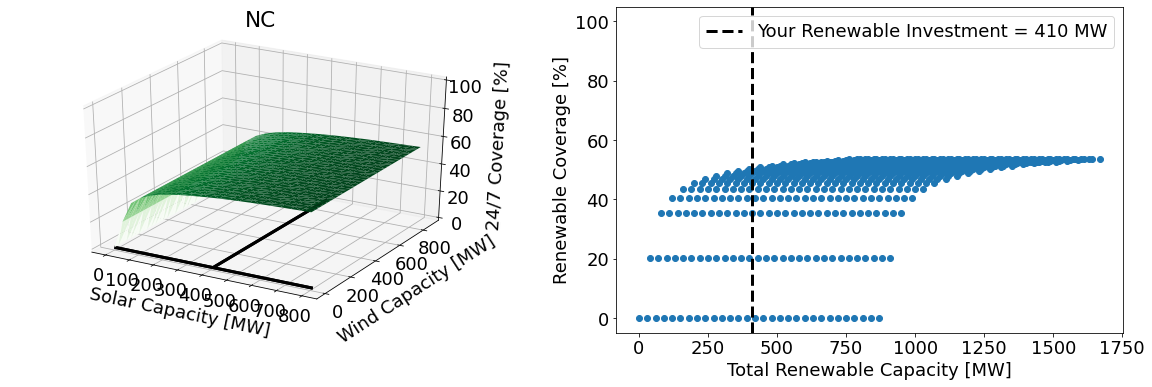

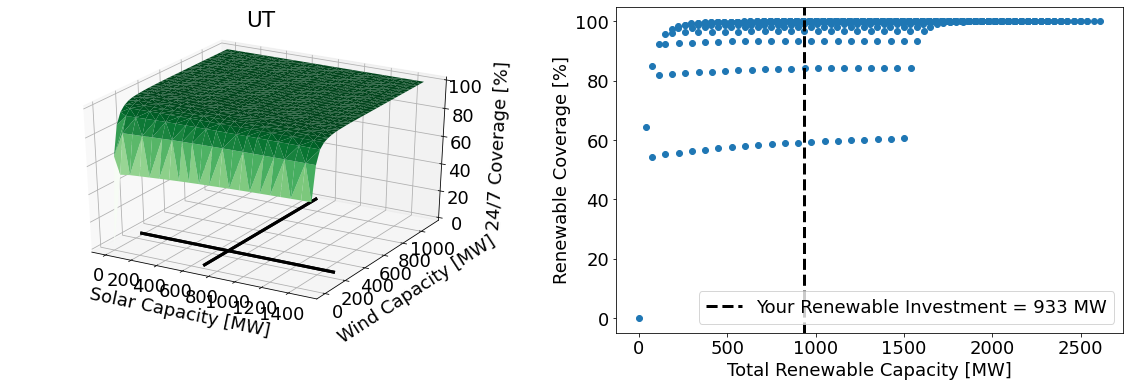

In [56]:
import numpy as np
from matplotlib.collections import LineCollection

ren_results_map = []
# maximum renewable capacity to be evaluated
max_wind_range = 400
max_sol_range = 400

for dc in dc_ba_map:
    ba = dc_ba_map[dc]
    d = extractDCRange(dc, START_DATE, END_DATE)
    avg_dc_pow = d.mean().item()

    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    db[db < 0] = 0
    max_dc_pow = d.max()
    wnd_db = db["WND"].fillna(0)
    sun_db = db["SUN"].fillna(0)
    max_wnd_cap = wnd_db.max()
    max_sun_cap = sun_db.max()
    #calculate avg carbon intensity of the grid
    carbon_intensity = calculateAVGCarbonIntensity(db)
    avg_carbon_intensity = carbon_intensity["carbon_intensity"].mean()

    results_ren = pd.DataFrame(
        columns=["sun_capacity", "wnd_capacity", "coverage", "extra_sun", "extra_wnd", "op_footprint"]
    )
    max_wind_range += ba_ppa_map[ba][0]
    max_sol_range += ba_ppa_map[ba][1]
    min_sun_to_247 = -1
    min_wnd_to_247 = -1
    for wnd_capacity in range(0, max_wind_range, int(max_wind_range / 30)):
        for sun_capacity in range(0, max_sol_range, int(max_sol_range / 20)):
            SUN_PPA_MW = sun_capacity
            WND_PPA_MW = wnd_capacity
            # print("PPA Amount --  SUN: ", SUN_PPA_MW, "WND: ", WND_PPA_MW)
            wnd_db_scaled = wnd_db
            sun_db_scaled = sun_db
            if max_wnd_cap != 0:
                wnd_db_scaled = wnd_db / max_wnd_cap * WND_PPA_MW
            if max_sun_cap != 0:
                sun_db_scaled = sun_db / max_sun_cap * SUN_PPA_MW
            projected_db = pd.concat([wnd_db_scaled, sun_db_scaled], axis=1)
            
            # Calculate renewable coverage
            renewable_coverage_ratio = utils.calculate_coverage((wnd_db_scaled + sun_db_scaled), d['avg_dc_power_mw'])

            if (renewable_coverage_ratio >= 100):
                min_ren_to_247 = min_wnd_to_247+min_wnd_to_247
                cur_ren_sum = wnd_capacity + sun_capacity
                if(min_ren_to_247 == -2 or min_ren_to_247 > cur_ren_sum):
                    min_sun_to_247 = sun_capacity
                    min_wnd_to_247 = wnd_capacity

            results_ren.loc[results_ren.shape[0]] = [
                sun_capacity,
                wnd_capacity,
                renewable_coverage_ratio,
                0,
                0,
                (avg_dc_pow * (100 - renewable_coverage_ratio) * 10 * 365 * 24)
                * avg_carbon_intensity
                / (10**6),
            ]

    i = 0
    for wnd_capacity in range(0, max_wind_range, int(max_wind_range / 10)):
        for sun_capacity in range(0, max_sol_range, int(max_sol_range / 10)):
            if(min_sun_to_247 - sun_capacity > 0):
                results_ren.loc[i]["extra_sun"] = min_sun_to_247 - sun_capacity
            elif (min_sun_to_247 == -1):
                results_ren.loc[i]["extra_sun"] = -1
            if(min_wnd_to_247 - wnd_capacity > 0):
                results_ren.loc[i]["extra_wnd"] = min_wnd_to_247 - wnd_capacity
            elif (min_wnd_to_247 == -1):
                results_ren.loc[i]["extra_wnd"] = -1
            i = i + 1
    
    # fig = plt.figure(figsize=plt.figaspect(0.5))
    fig = plt.figure(figsize=(20, 6))
    # FIRST PLOT
    plt.rcParams.update({"font.size": 18})
    ax = fig.add_subplot(1, 2, 1, projection="3d")
    ax.plot_trisurf(
        results_ren["sun_capacity"],
        results_ren["wnd_capacity"],
        results_ren["coverage"],
        cmap=plt.cm.Greens,
        linewidth=0.2,
    )
    # Your solar investment amount
    ba = dc_ba_map[dc]
    xi = [ba_ppa_map[ba][1], ba_ppa_map[ba][1]]
    yi = [0, max_wind_range]
    l = list(zip(xi, yi))
    lines = LineCollection((l, l), color="k", lw=3)
    ax.add_collection3d(lines)
    # Your wind investment amount
    xi = [0, max_sol_range]
    yi = [ba_ppa_map[ba][0], ba_ppa_map[ba][0]]
    l = list(zip(xi, yi))
    lines = LineCollection((l, l), color="k", lw=3)
    ax.add_collection3d(lines)

    ax.set_xlabel("Solar Capacity [MW]", labelpad=15)
    ax.set_ylabel("Wind Capacity [MW]", labelpad=15)
    ax.set_zlabel("24/7 Coverage [%]", labelpad=15)
    ax.set_title(dc)
    ax.set_zlim(0, 100)
    ax.dist = 11

    # SECOND PLOT
    ax = fig.add_subplot(1, 2, 2)
    # Do not plot wind data points for solar only regions
    #if(ba in ["SOCO", "DUK", "TVA"]):
    #    results_ren = results_ren[results_ren["wnd_capacity"]==0]
    ax.scatter(
        results_ren["sun_capacity"] + results_ren["wnd_capacity"], results_ren["coverage"]
    )
    tot_ren_cap = ba_ppa_map[ba][0] + ba_ppa_map[ba][1]
    ax.axvline(
        x=tot_ren_cap,
        linestyle="--",
        label="Your Renewable Investment = {} MW".format(tot_ren_cap),
        c="black",
        lw=3,
    )
    ax.set_xlabel("Total Renewable Capacity [MW]")
    ax.set_ylabel("Renewable Coverage [%]")
    ax.set_ylim(-5,105)
    plt.legend()
    plt.show()
    ren_results_map.append(pickle.loads(pickle.dumps(results_ren)))

# 3. Battery Analysis

**Charging:** Whenever  there  is  excess  renewable  supply  (i.e.  when  theamount  of  energy  produced  by  the  renewable  deployment  islarger  than  datacenter’s  demand),  batteries  will  be  charged.

**Discharging:** Whenever there is lack of renewable supply (i.e.when the amount of energy produced by the renewable deployment is smaller than datacenter’s demand) batteries will be discharged to power the datacenter.

The algorithm assumes a fixed charging speed and can charge as much as there is excess supply. Charging capacity does not change depending on the load of the batteries.

The next cell calculates the minimim battery capacity that needs to be deployed in order to make datacenter operate on renewable energy 24/7 given different solar and wind investments.

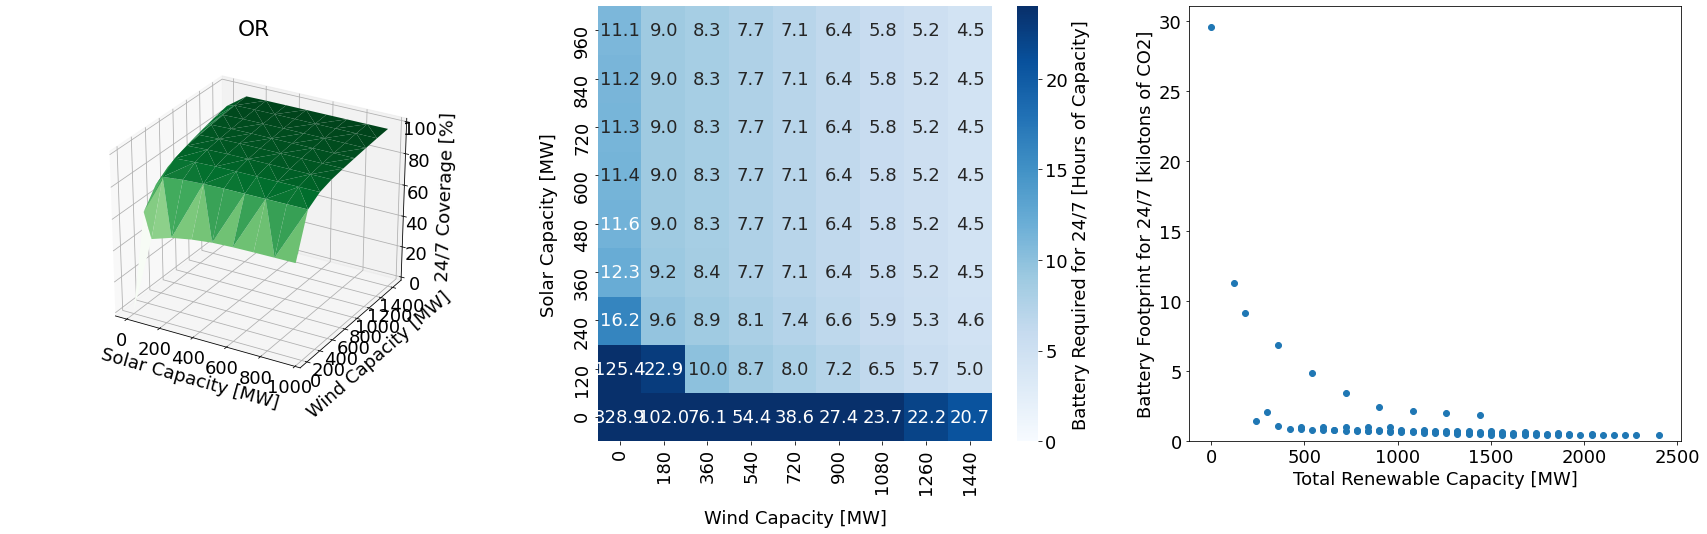

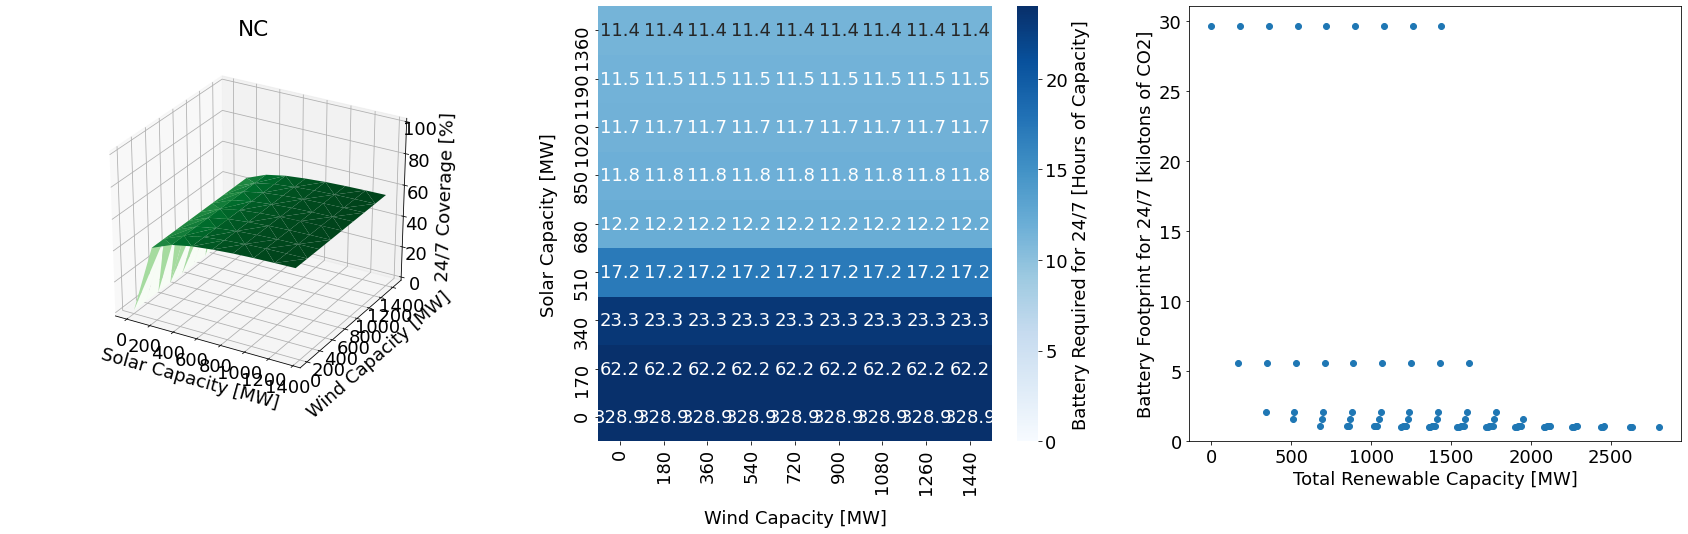

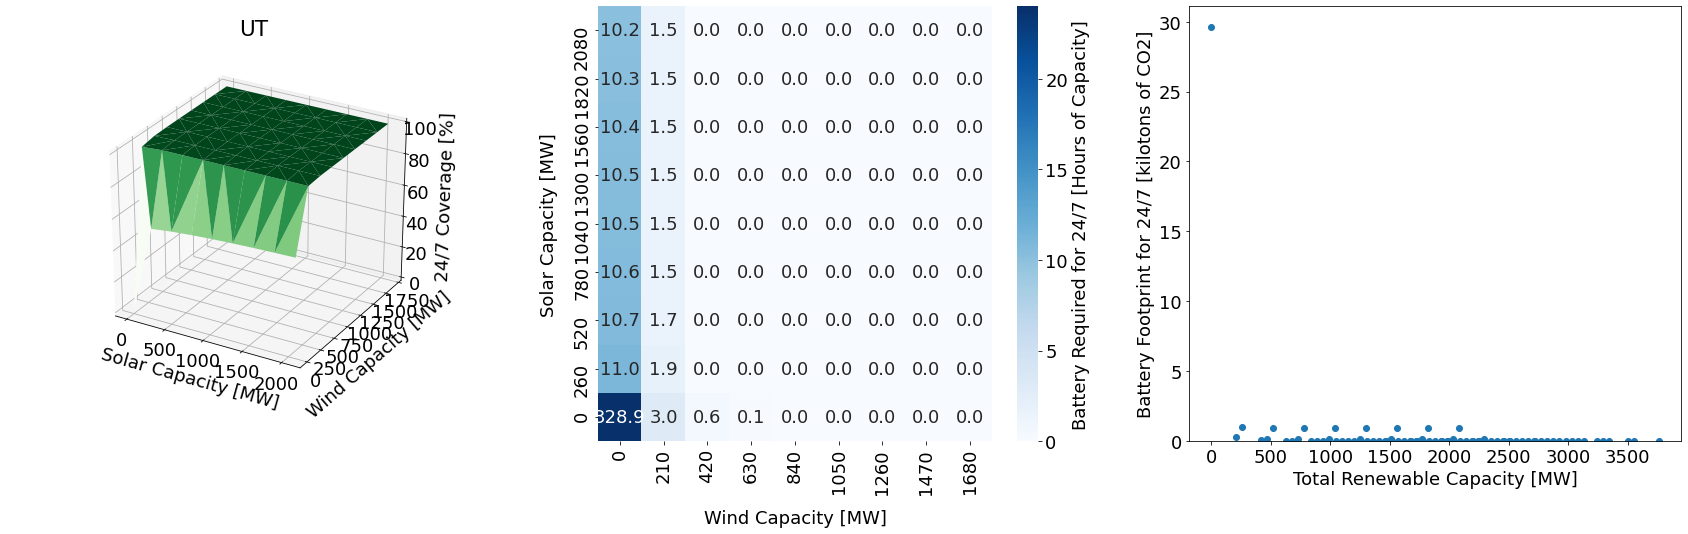

In [57]:
from matplotlib.collections import LineCollection
import seaborn as sns
import src.battery as bat
import importlib
importlib.reload(bat)

battery_results_map = []
# maximum renewable capacity to be evaluated
max_wind_range = 1000
max_sol_range = 1000

for dc in dc_ba_map:
    ba = dc_ba_map[dc]
    d = extractDCRange(dc, START_DATE, END_DATE)
    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    db[db < 0] = 0
    max_dc_pow = d.max().item()
    wnd_db = db["WND"].fillna(0)
    sun_db = db["SUN"].fillna(0)
    max_wnd_cap = wnd_db.max()
    max_sun_cap = sun_db.max()

    results_bat = pd.DataFrame(columns=["sun_capacity", "wnd_capacity", "coverage", "battery_cap"])

    max_wind_range += ba_ppa_map[ba][0]
    max_sol_range += ba_ppa_map[ba][1]
    for wnd_capacity in range(0, max_wind_range + 1, int(int(max_wind_range / 8) / 10) * 10):
        for sun_capacity in range(0, max_sol_range + 1, int(int(max_sol_range / 8) / 10) * 10):
            SUN_PPA_MW = sun_capacity
            WND_PPA_MW = wnd_capacity
            wnd_db_scaled = wnd_db
            sun_db_scaled = sun_db
            if max_wnd_cap != 0:
                wnd_db_scaled = wnd_db / max_wnd_cap * WND_PPA_MW
            if max_sun_cap != 0:
                sun_db_scaled = sun_db / max_sun_cap * SUN_PPA_MW
            projected_db = pd.concat([wnd_db_scaled, sun_db_scaled], axis=1)
            
            ren_mw = wnd_db_scaled + sun_db_scaled
            battery_cap_needed = bat.calculate_247_battery_capacity(ren_mw, d)
            
            # Calculate renewable coverage
            renewable_coverage_ratio = utils.calculate_coverage(ren_mw, d['avg_dc_power_mw'])
    
            results_bat.loc[results_bat.shape[0]] = [
                sun_capacity,
                wnd_capacity,
                renewable_coverage_ratio,
                battery_cap_needed,
            ]

    # Plot the results
    fig = plt.figure(figsize=(30, 8))
    # FIRST PLOT
    plt.rcParams.update({"font.size": 18})
    ax = fig.add_subplot(1, 3, 1, projection="3d")
    ax.plot_trisurf(
        results_bat["sun_capacity"],
        results_bat["wnd_capacity"],
        results_bat["coverage"],
        cmap=plt.cm.Greens,
        linewidth=0.2,
    )
    ax.set_xlabel("Solar Capacity [MW]", labelpad=15)
    ax.set_ylabel("Wind Capacity [MW]", labelpad=15)
    ax.set_zlabel("24/7 Coverage [%]", labelpad=15)
    ax.set_title(dc)
    ax.set_zlim(0, 100)
    ax.dist = 13
    # SECOND PLOT
    ax = fig.add_subplot(1, 3, 2)
    results_bat.drop(["coverage"], axis=1, inplace=True)
    results_bat = results_bat.fillna(-1).astype("int")
    results_bat["battery_cap"] = results_bat["battery_cap"] / max_dc_pow
    results_bat["battery_cap"] = results_bat["battery_cap"][results_bat["battery_cap"] >= 0.0]
    rp = results_bat.pivot(index="sun_capacity", columns="wnd_capacity", values="battery_cap")
    # pd.options.display.float_format = '{:,}'.format
    s = sns.heatmap(
        rp,
        cmap=plt.cm.Blues,
        ax=ax,
        cbar_kws={"label": "Battery Required for 24/7 [Hours of Capacity]"},
        annot=True,
        fmt=".1f",
        vmin=0,
        vmax=24,
    )
    ax.invert_yaxis()
    ax.set_ylabel("Solar Capacity [MW]", labelpad=15)
    ax.set_xlabel("Wind Capacity [MW]", labelpad=15)
    s.set_facecolor("whitesmoke")

    # THIRD PLOT
    ax = fig.add_subplot(133, xlabel="Total Renewable Capacity [MW]", ylabel="Battery Footprint for 24/7 [kilotons of CO2]")
    results_bat["battery_cap"] = results_bat["battery_cap"][
        results_bat["battery_cap"] >= 0.0
    ]  # do not plot -1s, infeasible battery cases
    # embodied carbon footprint of batteries for 10 years, in terms of kilotons of CO2 (divide by 1000)
    results_bat["battery_cap"] = (
        results_bat["battery_cap"] * (embodied_battery_footprint / 1000) * (10 / battery_lifetime)
    )
    ax.scatter(results_bat["sun_capacity"] + results_bat["wnd_capacity"], results_bat["battery_cap"])
    ax.set_ylim(bottom=0)
    plt.show()
    battery_results_map.append(pickle.loads(pickle.dumps(results_bat)))

# 4. Carbon Aware Scheduling

## 4.1. Carbon Aware Scheduling using Grid Energy Mix
In this scenario, datacenter draws energy directly from the grid with no additional renewable investments. Carbon intensity of the grid varies hourly based on the generation mix which can include renewable and non-renewable resources.
Carbon aware scheduling mechanism moves the workloads from high carbon intense times to the low carbon intensity times of the day.

You can configure `max_extra_capacity` and `max_flexible_work_ratio` to specify maximum additional server capacity to evaluate and maximum % of flexible workload ratio that can be shifted.

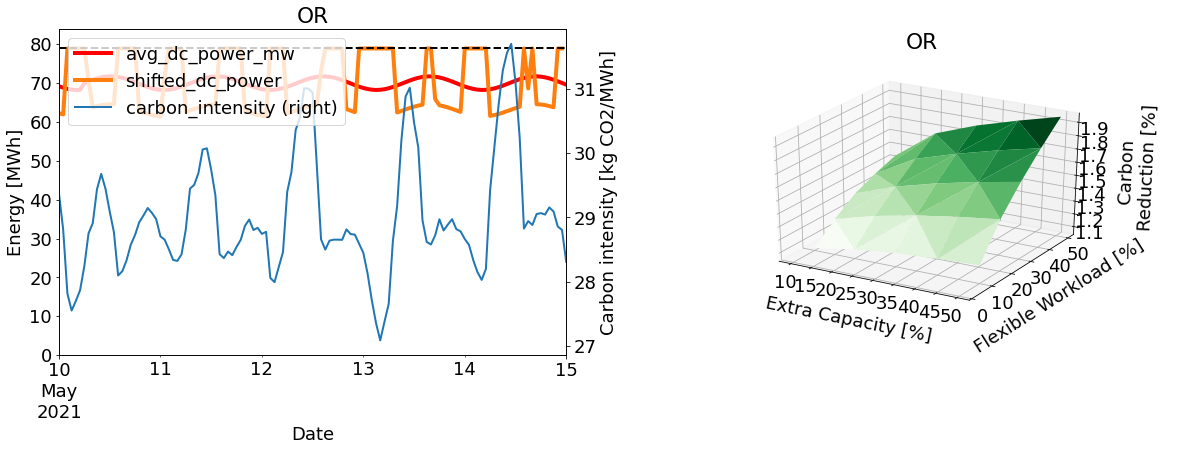

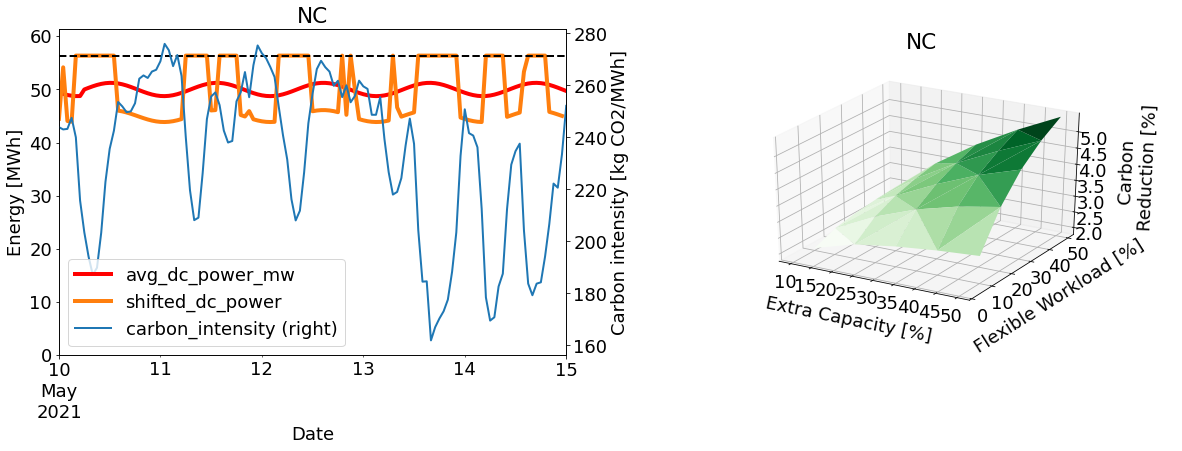

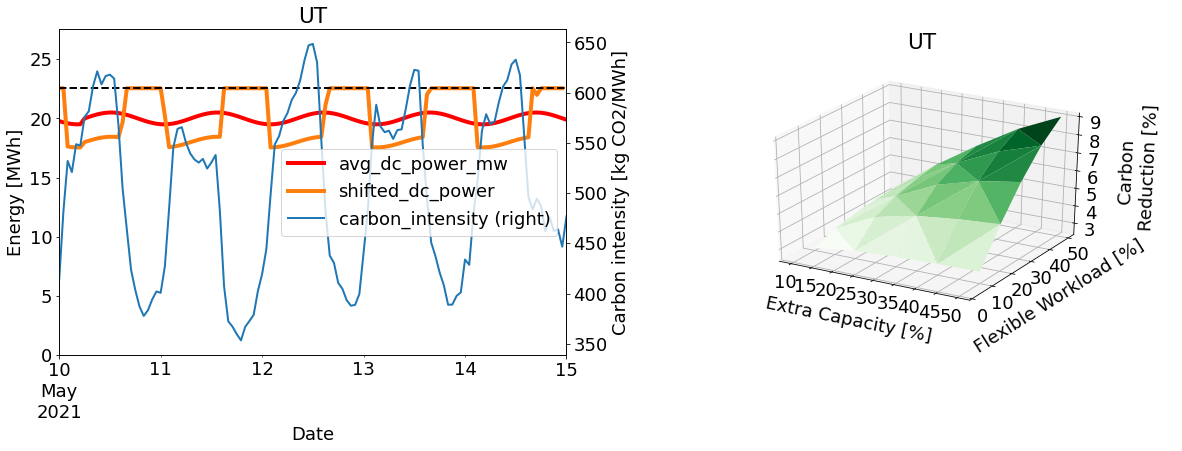

In [12]:
import matplotlib.pyplot as plt

START_DATE = "2021-05-10"
END_DATE = "2021-05-15"

# Maximum additional server capacity to evaluate (%)
max_extra_capacity = 50  # i.e. peak can increase up to 50% of the current capacity
# maximum % of flexible workload ratio to be evaluated (%)
max_flexible_work_ratio = 50  # 50% of the workloads at every hour are flexible to shift within a day

for dc in dc_ba_map:
    fig = plt.figure(figsize=(20, 6))
    d = extractDCRange(dc, START_DATE, END_DATE)
    cur_cap = d.max().item()
    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)

    carbon_intensity = calculateAVGCarbonIntensity(db)
    
    # join dc & carbon intensity data frames
    d.index = pd.to_datetime(d.index).tz_localize("UTC")
    df_all = d.join(carbon_intensity)

    results = pd.DataFrame(
        columns=["extra_capacity", "flexible_work_ratio", "imbalanced_cost", "balanced_cost", "carbon_reduction"]
    )

    # max capacity can range from 5% to 50% above current capacity
    for extra_capacity in range(10, max_extra_capacity + 1, 10):
        max_cap = cur_cap + cur_cap * extra_capacity / 100
        # % of flexible workload
        for flexible_work_ratio in range(10, max_flexible_work_ratio + 1, 10):
            # work on 24 hour basis
            # sort the df in terms of ascending carbon
            # take flexible_work_ratio from the highest carbon intensity hours
            # to lowest ones until max_cap is hit
            # until avg carbon is hit or shifting does not reduce
            balanced_df = []
            for i in range(0, df_all.shape[0], 24):
                sorted_df = df_all[i : i + 24].sort_values(by=["carbon_intensity", "avg_dc_power_mw"])
                start = 0
                end = 23
                if sorted_df.shape[0] < 23:
                    break
                work_to_move = 0
                while start < end:
                    available_space = max_cap - sorted_df["avg_dc_power_mw"].iloc[start]
                    if work_to_move <= 0:
                        work_to_move = flexible_work_ratio / 100 * sorted_df["avg_dc_power_mw"].iloc[end]
                    if available_space > work_to_move:
                        sorted_df["avg_dc_power_mw"].iloc[start] = (
                            sorted_df["avg_dc_power_mw"].iloc[start] + work_to_move
                        )
                        sorted_df["avg_dc_power_mw"].iloc[end] = sorted_df["avg_dc_power_mw"].iloc[end] - work_to_move
                        end = end - 1
                        work_to_move = 0
                    else:
                        sorted_df["avg_dc_power_mw"].iloc[start] = max_cap
                        sorted_df["avg_dc_power_mw"].iloc[end] = (
                            sorted_df["avg_dc_power_mw"].iloc[end] - available_space
                        )
                        work_to_move = work_to_move - available_space
                        start = start + 1
                balanced_df.append(sorted_df)

            final_balanced_df = pd.concat(balanced_df).sort_values(by=["index"])
            # calculate total carbon cost
            imbalanced_cost = (d["avg_dc_power_mw"] * carbon_intensity["carbon_intensity"]).sum(axis=0)
            balanced_cost = (final_balanced_df["avg_dc_power_mw"] * carbon_intensity["carbon_intensity"]).sum(axis=0)
            # print(extra_capacity, flexible_work_ratio, imbalanced_cost, balanced_cost, (imbalanced_cost-balanced_cost)/balanced_cost*100)
            results.loc[results.shape[0]] = [
                extra_capacity,
                flexible_work_ratio,
                imbalanced_cost,
                balanced_cost,
                (imbalanced_cost - balanced_cost) / balanced_cost * 100,
            ]

            # plot
            if extra_capacity == 10 and flexible_work_ratio == 10:
                ax = fig.add_subplot(1, 2, 1)
                d.plot(kind="line", color="red", lw=4, label="dc_power", ax=ax)
                carbon_intensity.plot(kind="line", stacked=False, title=dc, ax=ax, secondary_y=True, lw=2)
                final_balanced_df["avg_dc_power_mw"].plot(
                    kind="line", stacked=False, lw=4, label="shifted_dc_power", ax=ax
                )
                ax.legend(loc="upper left")
                ax.set_xlabel("Date")
                ax.set_ylabel("Energy [MWh]")
                ax.right_ax.set_ylabel("Carbon intensity [kg CO2/MWh]")
                ax.set_ylim(0, max_cap + 5)
                ax.axhline(y=max_cap, color="black", linestyle="--", lw=2)
                ax.get_legend().remove()
                handles, labels = [], []
                for ax in fig.axes:
                    for h, l in zip(*ax.get_legend_handles_labels()):
                        handles.append(h)
                        labels.append(l)
                plt.legend(handles, labels)

    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.plot_trisurf(
        results["extra_capacity"],
        results["flexible_work_ratio"],
        results["carbon_reduction"],
        cmap=plt.cm.Greens,
        linewidth=0.2,
    )
    ax.set_xlabel("Extra Capacity [%]", labelpad=25)
    ax.set_ylabel("Flexible Workload [%]", labelpad=20)
    ax.set_zlabel("Carbon \n Reduction [%]", labelpad=25)
    ax.set_yticks(np.arange(0, 51, step=10))
    ax.set_title(dc)
    ax.dist = 13
    plt.show()

## 4.2. Carbon Aware Scheduling for 24/7

This is slightly different than the Grid-Mix scenario. Here carbon aware scheduling is be used to increase 24/7 renewable coverage by shifting workloads from times when there is lack of renewable energy
to times with excess supply.

You can configure `max_extra_capacity` and `max_flexible_work_ratio` to specify maximum additional server capacity to evaluate and maximum % of flexible workload ratio that can be shifted.

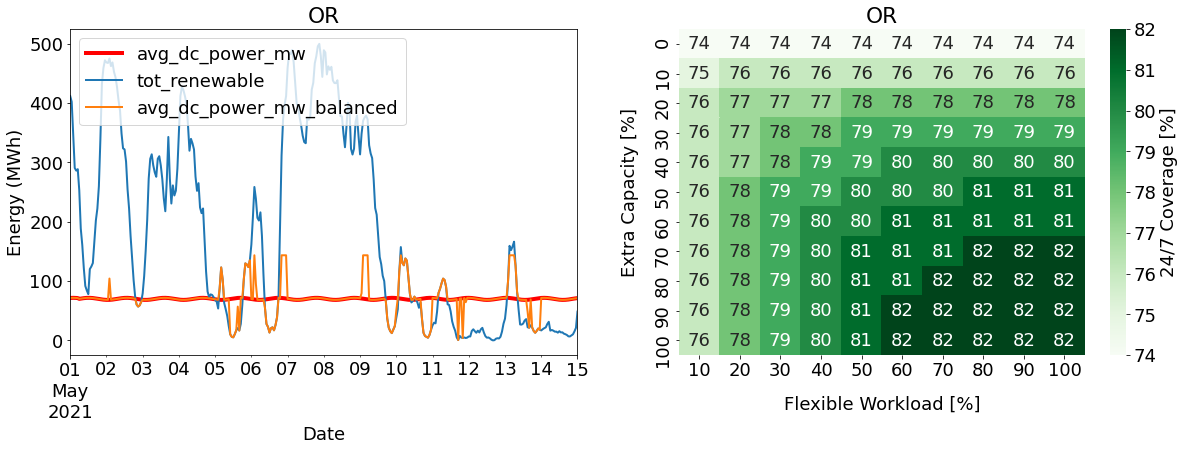

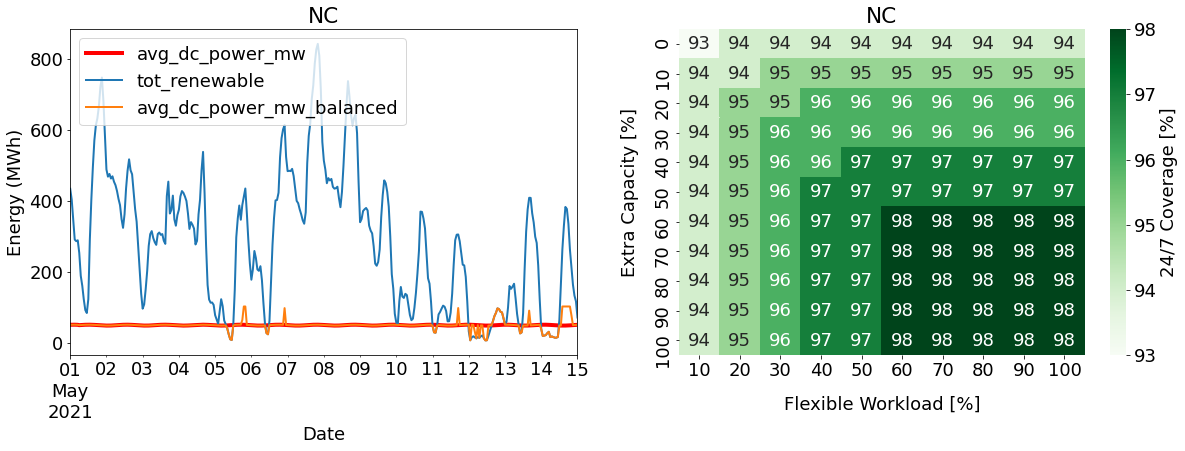

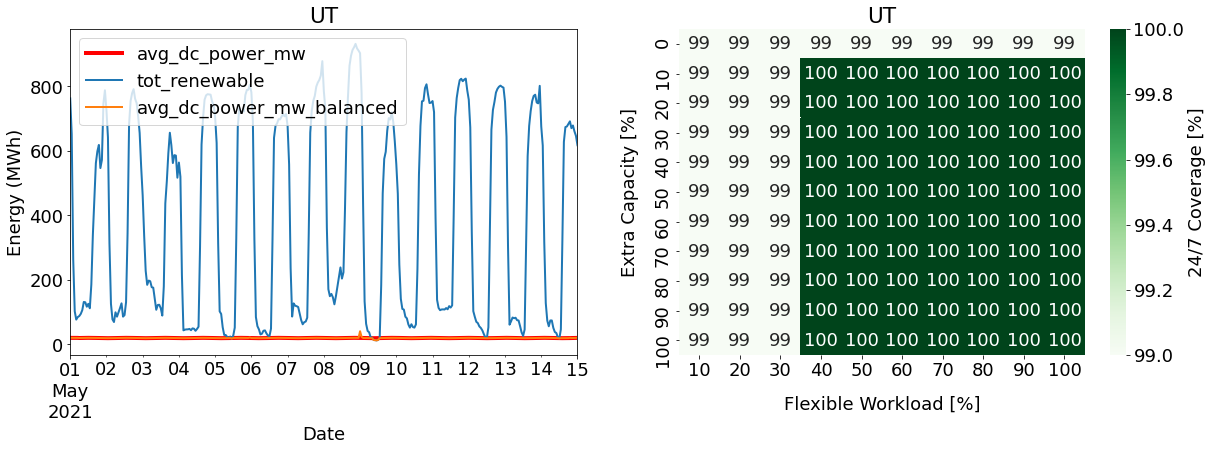

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from src.cas import *

# Maximum additional server capacity to evaluate (%)
max_extra_capacity = 100 # i.e. peak can increase up to 50% of the current capacity
# maximum % of flexible workload ratio to be evaluated (%)
max_flexible_work_ratio = 100 # all of the workloads at every hour are flexible to shift within a day

for dc in dc_ba_map:
    fig = plt.figure(figsize=(20, 6))
    ba = dc_ba_map[dc]
    d = extractDCRange(dc, START_DATE, END_DATE)
    cur_cap = d.max().item()

    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    db[db < 0] = 0
    wnd_db = db["WND"].fillna(0)
    sun_db = db["SUN"].fillna(0)
    max_wnd_cap = wnd_db.max()
    max_sun_cap = sun_db.max()
    SUN_PPA_MW = ba_ppa_map[ba][1]
    WND_PPA_MW = ba_ppa_map[ba][0]
    if max_wnd_cap != 0:
        wnd_db_scaled = wnd_db / max_wnd_cap * WND_PPA_MW
    if max_sun_cap != 0:
        sun_db_scaled = sun_db / max_sun_cap * SUN_PPA_MW
    projected_db = pd.concat([wnd_db_scaled, sun_db_scaled], axis=1)

    sum_db = wnd_db_scaled + sun_db_scaled
    sum_db.rename("tot_renewable", inplace=True)
    # join dc & total renewable energy data frames
    d.index = pd.to_datetime(d.index).tz_localize("UTC")
    df_all = d.join(sum_db)

    results = pd.DataFrame(
        columns=[
            "extra_capacity",
            "flexible_work_ratio",
            "imbalanced_coverage",
            "balanced_coverage",
        ]
    )

    # max capacity can range from 0% to max_allowed_extra_cap
    for extra_capacity in range(0, max_extra_capacity+1, 10):
        max_cap = cur_cap + cur_cap * extra_capacity / 100
        # % of flexible workload
        for flexible_work_ratio in range(10, max_flexible_work_ratio+1, 10):
            # apply cas algorithm from cas.py
            final_balanced_df = cas(df_all, flexible_work_ratio, max_cap)

            # Calculate renewable coverage
            balanced_coverage = utils.calculate_coverage(final_balanced_df["tot_renewable"], final_balanced_df["avg_dc_power_mw"])

            results.loc[results.shape[0]] = [
                extra_capacity,
                flexible_work_ratio,
                0,
                balanced_coverage,
            ]

            # plot
            if extra_capacity == 100 and flexible_work_ratio == 100:
                ax = fig.add_subplot(1, 2, 1)
                d.plot(kind="line", color="red", lw=4, ax=ax)
                sum_db.plot(
                    kind="line",
                    stacked=False,
                    title=dc,
                    ax=ax,
                    lw=2,
                )
                final_balanced_df["avg_dc_power_mw"].plot(
                    kind="line", stacked=False, lw=2, label="avg_dc_power_mw_balanced"
                )
                ax.legend(loc="upper left")
                ax.set_xlabel("Date")
                ax.set_ylabel("Energy (MWh)")

    ax = fig.add_subplot(1, 2, 2)
    results = results.fillna(-1).astype("int")
    rp = results.pivot(
        index="extra_capacity",
        columns="flexible_work_ratio",
        values="balanced_coverage",
    )
    s = sns.heatmap(
        rp,
        cmap=plt.cm.Greens,
        ax=ax,
        cbar_kws={"label": "24/7 Coverage [%]"},
        annot=True,
        fmt="d",
    )
    ax.set_xlabel("Flexible Workload [%]", labelpad=15)
    ax.set_ylabel("Extra Capacity [%]", labelpad=15)
    s.set_facecolor("xkcd:coral")
    ax.set_title(dc)
    ax.dist = 13
    plt.show()

## 4.3. Carbon Aware Scheduling for 24/7 with Different Renewable Installation Capacities

Next analysis calculates what is the minimum additional capacity required **to reach 24/7** using carbon aware scheduling at different renewable investment amounts.

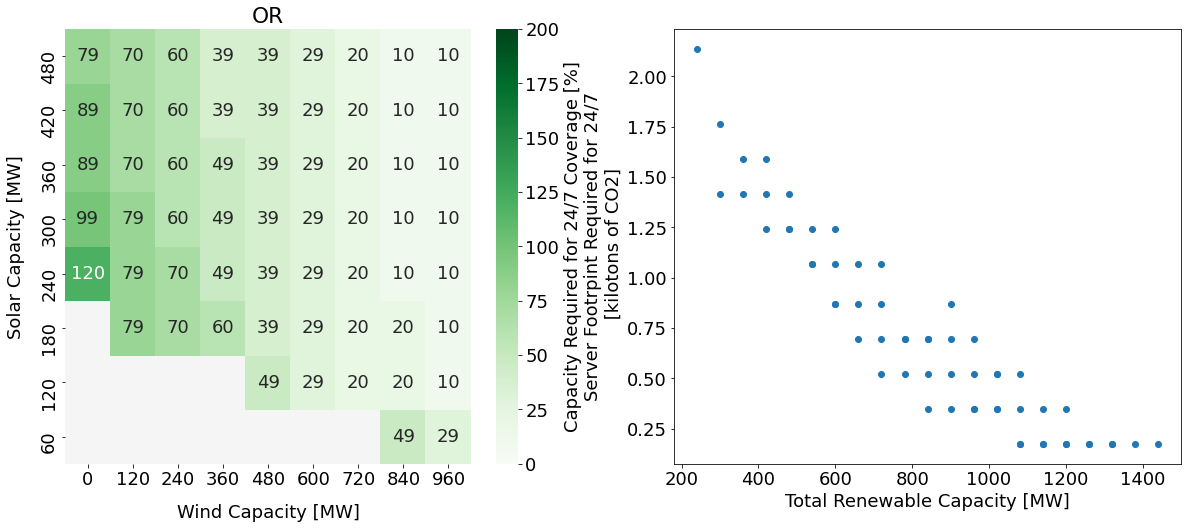

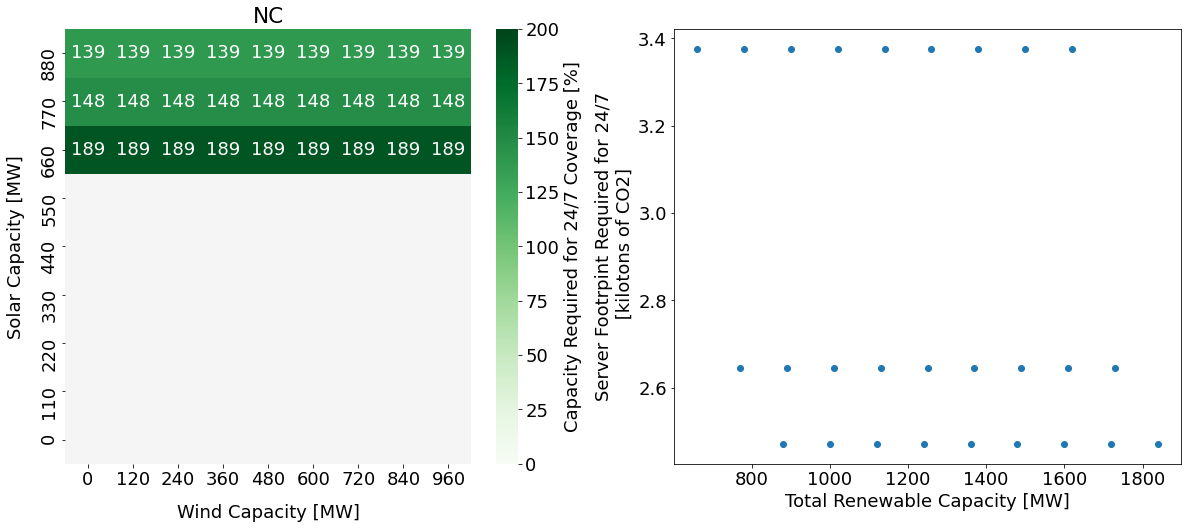

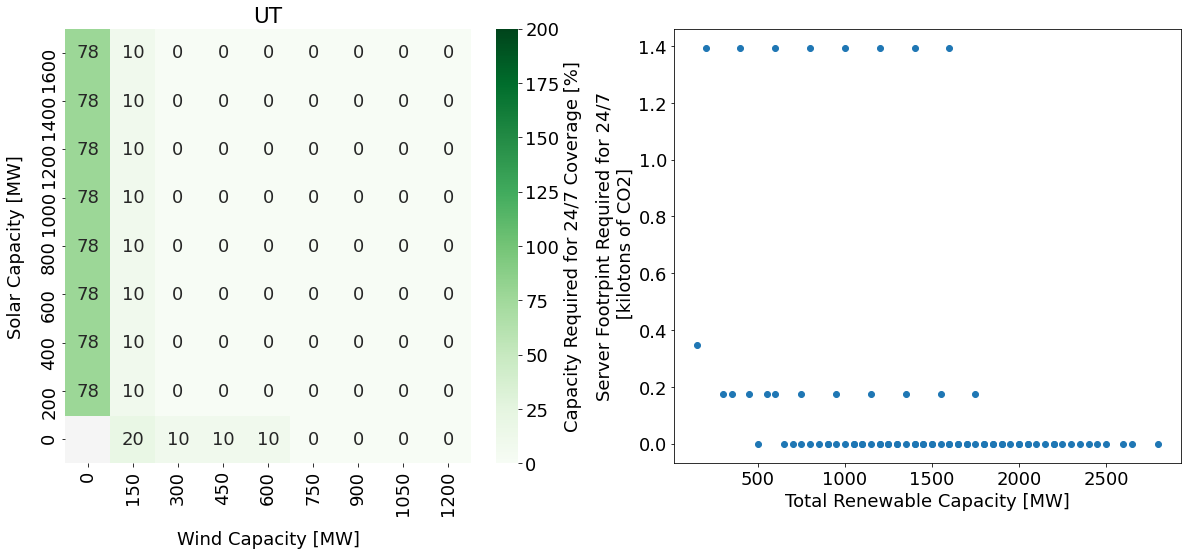

In [14]:
from src.cas import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
import pickle
import pandas as pd

server_results_map = []
# maximum renewable capacity to be evaluated
max_wind_range = 500
max_sol_range = 500
# Maximum additional server capacity to evaluate (%)
max_extra_capacity = 200 # i.e. peak can increase up to 50% of the current capacity
# maximum % of flexible workload ratio to be evaluated (%)
max_flexible_work_ratio = 100 # all of the workloads at every hour are flexible to shift within a day

for dc in dc_ba_map:
    ba = dc_ba_map[dc]
    d = extractDCRange(dc, START_DATE, END_DATE)
    cur_cap = d.max().item()
    d.index = pd.to_datetime(d.index).tz_localize("UTC")

    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    db[db < 0] = 0
    wnd_db = db["WND"].fillna(0)
    sun_db = db["SUN"].fillna(0)

    max_wnd_cap = wnd_db.max()
    max_sun_cap = sun_db.max()

    results_server = pd.DataFrame(
        columns=[
            "sun_capacity",
            "wnd_capacity",
            "extra_capacity",
        ]
    )
    max_wind_range += ba_ppa_map[ba][0]
    max_sol_range += ba_ppa_map[ba][1]

    for wnd_capacity in range(0, max_wind_range+1, int(int(max_wind_range / 8)/10)*10):
        for sun_capacity in range(0, max_sol_range+1, int(int(max_sol_range / 8)/10)*10):
            SUN_PPA_MW = sun_capacity
            WND_PPA_MW = wnd_capacity
            wnd_db_scaled = wnd_db
            sun_db_scaled = sun_db
            if max_wnd_cap != 0:
                wnd_db_scaled = wnd_db / max_wnd_cap * WND_PPA_MW
            if max_sun_cap != 0:
                sun_db_scaled = sun_db / max_sun_cap * SUN_PPA_MW
            projected_db = pd.concat([wnd_db_scaled, sun_db_scaled], axis=1)

            sum_db = wnd_db_scaled + sun_db_scaled
            sum_db.rename("tot_renewable", inplace=True)
            # join dc & total renewable energy data frames
            df_all = d.join(sum_db)

            # check if we need carbon aware scheduling at all
            coverage = utils.calculate_coverage(df_all["tot_renewable"], df_all["avg_dc_power_mw"])

            # print(extra_capacity, flexible_work_ratio, imbalanced_cost, balanced_cost, (imbalanced_cost-balanced_cost)/balanced_cost*100)
            if coverage => 100.0:
                results_server.loc[results_server.shape[0]] = [
                    sun_capacity,
                    wnd_capacity,
                    0,
                ]
                continue

            # do carbon aware scheduling
            # % of flexible workload
            for flexible_work_ratio in range(max_flexible_work_ratio, max_flexible_work_ratio+1, 10):
                for extra_capacity in range(10, max_extra_capacity+1, 10):
                    max_cap = cur_cap + cur_cap * extra_capacity / 100
                    # apply cas algorithm from cas.py
                    final_balanced_df = cas(df_all, flexible_work_ratio, max_cap)
                    
                    # calculate coverage
                    balanced_coverage = utils.calculate_coverage(final_balanced_df["tot_renewable"], final_balanced_df["avg_dc_power_mw"])
            
                    if balanced_coverage >= 100.0:
                        results_server.loc[results_server.shape[0]] = [
                            sun_capacity,
                            wnd_capacity,
                            cur_cap * extra_capacity / 100,
                        ]
                        break
                    elif ba == "DUK" and flexible_work_ratio == 100 and extra_capacity == 200:
                        results_server.loc[results_server.shape[0]] = [
                            sun_capacity,
                            wnd_capacity,
                            -1,
                        ]
                    # plot
                    if extra_capacity == 101 and flexible_work_ratio == 101:
                        ax = d.plot(kind="line", color="red", lw=4)
                        sum_db.plot(
                            kind="line",
                            stacked=False,
                            title=dc,
                            ax=ax,
                            lw=2,
                        )
                        final_balanced_df["avg_dc_power_mw"].plot(
                            kind="line",
                            stacked=False,
                            lw=2,
                            label="avg_dc_power_mw_balanced",
                        )
                        ax.legend(loc="upper left")
                        ax.set_xlabel("Date")
                        ax.set_ylabel("Energy (MWh)")
                        ##plt.ylim(10, 150000)
                        plt.show()

    #if results_server.empty:
    #    continue  # do not plot this ba
    # print(results_server)
    fig = plt.figure(figsize=(20, 8))
    plt.rcParams.update({"font.size": 18})
    # FIRST PLOT
    ax = fig.add_subplot(1, 2, 1)
    results_server = results_server.fillna(-1).astype("int")
    #results_server.drop_duplicates(subset=['sun_capacity', 'wnd_capacity', 'extra_capacity'], keep='first', inplace=True)
    results_server["extra_capacity"] = (results_server["extra_capacity"])/cur_cap*100
    results_server["extra_capacity"] = results_server["extra_capacity"][
        results_server["extra_capacity"] >= 0.0
    ] 
    rp = results_server.pivot(
        index="sun_capacity", columns="wnd_capacity", values="extra_capacity"
    )
    s = sns.heatmap(
        rp,
        cmap=plt.cm.Greens,
        ax=ax,
        cbar_kws={"label": "Capacity Required for 24/7 Coverage [%]"},
        annot=True,
        fmt=".0f",
        vmin=0, vmax=200
    )
    ax.invert_yaxis()
    ax.set_xlabel("Wind Capacity [MW]", labelpad=15)
    ax.set_ylabel("Solar Capacity [MW]", labelpad=15)
    s.set_facecolor("whitesmoke")
    ax.set_title(dc)
    ax.dist = 13

    # SECOND PLOT
    ax = fig.add_subplot(122, xlabel="Total Renewable Capacity [MW]", ylabel="Server Footrpint Required for 24/7\n [kilotons of CO2]")
    results_server["extra_capacity"] = results_server["extra_capacity"] * (embodied_server_footprint / 1000) * (10 / server_lifetime)
    ax.scatter(
        results_server["sun_capacity"] + results_server["wnd_capacity"], results_server["extra_capacity"]
    )
    plt.show()
    server_results_map.append(pickle.loads(pickle.dumps(results_server)))

# 5. Embodied Footprint Analysis

Now, we add on embodied carbon footprint of each solution into the analysis. For each solution, we take into account the embodied footprint coming from building new the solar and wind farms, from manufacturing of the batteries and additional server capacity.

## 5.1. Embodied Footprint of Building Renewable Farms

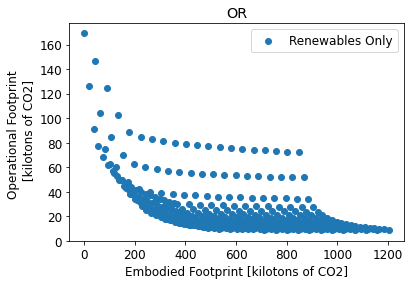

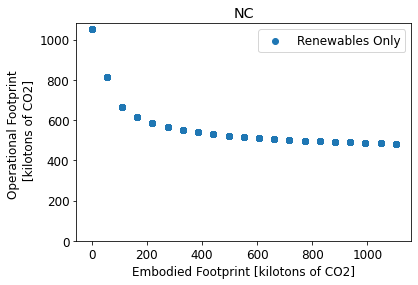

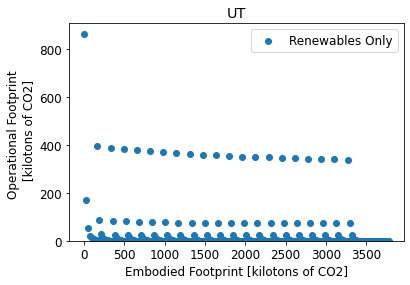

In [67]:
import numpy as np
import seaborn as sns
from matplotlib.collections import LineCollection
from datetime import datetime

ba_id = 0
ren_results_map_final = []
max_wind_range = 500
max_sol_range = 500

for dc in dc_ba_map:
    ba = dc_ba_map[dc]
    d = extractDCRange(dc, START_DATE, END_DATE)
    avg_dc_pow = d.mean().item()
    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    carbon_intensity = calculateAVGCarbonIntensity(db)
    avg_carbon_intensity = carbon_intensity["carbon_intensity"].mean()

    wnd_db = db["WND"].fillna(0)
    sun_db = db["SUN"].fillna(0)
    max_wnd_cap = wnd_db.max()
    max_sun_cap = sun_db.max()

    results_ren = pd.DataFrame(
        columns=[
            "sun_capacity",
            "wnd_capacity",
            "coverage",
            "op_footprint",
            "emb_footprint",
        ]
    )
    max_wind_range += ba_ppa_map[ba][0]
    max_sol_range += ba_ppa_map[ba][1]
    min_sun_to_247 = -1
    min_wnd_to_247 = -1
    for wnd_capacity in range(0, max_wind_range, int(max_wind_range / 20)):
        for sun_capacity in range(0, max_sol_range, int(max_sol_range / 20)):
            SUN_PPA_MW = sun_capacity
            WND_PPA_MW = wnd_capacity
            wnd_db_scaled = wnd_db
            sun_db_scaled = sun_db
            if max_wnd_cap != 0:
                wnd_db_scaled = wnd_db / max_wnd_cap * WND_PPA_MW
            if max_sun_cap != 0:
                sun_db_scaled = sun_db / max_sun_cap * SUN_PPA_MW
            projected_db = pd.concat([wnd_db_scaled, sun_db_scaled], axis=1)

            # calculate coverage
            renewable_coverage_ratio = utils.calculate_coverage((wnd_db_scaled + sun_db_scaled), d['avg_dc_power_mw'])
            
            if renewable_coverage_ratio >= 100:
                min_ren_to_247 = min_wnd_to_247 + min_wnd_to_247
                cur_ren_sum = wnd_capacity + sun_capacity
                if min_ren_to_247 == -2 or min_ren_to_247 > cur_ren_sum:
                    min_sun_to_247 = sun_capacity
                    min_wnd_to_247 = wnd_capacity

            op_footprint = (avg_dc_pow * ((100 - renewable_coverage_ratio)/100) * 10 * 365 * 24) * avg_carbon_intensity / (10**6)  # 10 years of time, kilotons of Co2
            delta = int((datetime.strptime(END_DATE, "%Y-%m-%d") - datetime.strptime(START_DATE, "%Y-%m-%d")).days)
            tot_wind_energy = wnd_db_scaled.sum()/delta*10*365 # normalize to 10 years of operation
            tot_sun_energy = sun_db_scaled.sum()/delta*10*365 # normalize to 10 years of operation
            emb_footprint = (tot_sun_energy * embodied_solar_farm_footprint + tot_wind_energy * embodied_wind_farm_footprint) / (10**6)  # 10 years of time, kilotons of Co2
                
            results_ren.loc[results_ren.shape[0]] = [
                sun_capacity,
                wnd_capacity,
                renewable_coverage_ratio,
                op_footprint,
                emb_footprint
            ]

    fig = plt.figure(figsize=(6, 4))
    ax = fig.gca()
    plt.rcParams.update({"font.size": 12})
    ax.scatter(
        results_ren["emb_footprint"],
        results_ren["op_footprint"],
        label="Renewables Only",
        marker='o'
    )
    plt.title(dc)
    ba_id = ba_id + 1
    ax.set(xlabel="Embodied Footprint [kilotons of CO2]", ylabel="Operational Footprint \n [kilotons of CO2]")
    ax.set_ylim(bottom=0)
    plt.legend()
    plt.show()
    ren_results_map_final.append(pickle.loads(pickle.dumps(results_ren)))


## 5.2 Embodied Footprint of Batteries

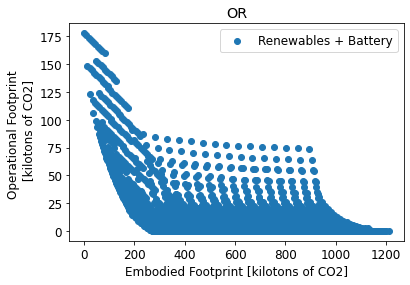

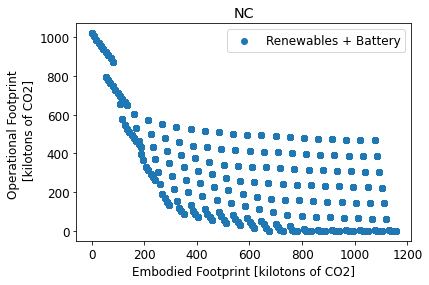

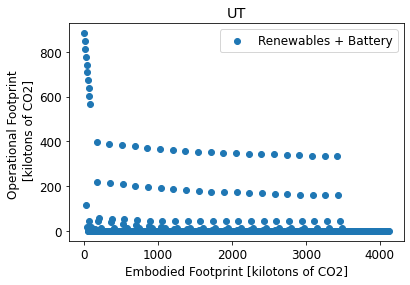

In [37]:
import numpy as np
import seaborn as sns
from matplotlib.collections import LineCollection
import src.battery as bat
import importlib
importlib.reload(bat)

# store the final embodied and operational footprint numbers in this map
battery_results_map_final = []
# maximum battery capacity to be evaluated
max_bat_range = 1000 #mwh
# maximum renewable capacity to be evaluated
max_wind_range = 500
max_sol_range = 500

for dc in dc_ba_map:
    ba = dc_ba_map[dc]
    d = extractDCRange(dc, START_DATE, END_DATE)
    avg_dc_pow = d.mean().item()
    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    db[db < 0] = 0
    wnd_db = db["WND"].fillna(0)
    sun_db = db["SUN"].fillna(0)
    max_wnd_cap = wnd_db.max()
    max_sun_cap = sun_db.max()
    #calculate avg carbon intensity of the grid
    carbon_intensity = calculateAVGCarbonIntensity(db)
    avg_carbon_intensity = carbon_intensity["carbon_intensity"].mean()

    results_bat = pd.DataFrame(
        columns=["sun_capacity", "wnd_capacity", "battery_capacity", "coverage", "op_footprint", "emb_footprint"]
    )
    max_wind_range += ba_ppa_map[ba][0]
    max_sol_range += ba_ppa_map[ba][1]

    for battery_cap in range(0, max_bat_range, 100):
        for wnd_capacity in range(0, max_wind_range, int(max_wind_range / 20)):
            for sun_capacity in range(0, max_sol_range, int(max_sol_range / 20)):
                SUN_PPA_MW = sun_capacity
                WND_PPA_MW = wnd_capacity
                wnd_db_scaled = wnd_db
                sun_db_scaled = sun_db
                if max_wnd_cap != 0:
                    wnd_db_scaled = wnd_db / max_wnd_cap * WND_PPA_MW
                if max_sun_cap != 0:
                    sun_db_scaled = sun_db / max_sun_cap * SUN_PPA_MW
                projected_db = pd.concat([wnd_db_scaled, sun_db_scaled], axis=1)
                ren_mw = wnd_db_scaled + sun_db_scaled
                
                # apply battery analysis
                tot_non_ren_mw, ren_mw_with_battery = bat.apply_battery(battery_cap, ren_mw, d)

                renewable_coverage_ratio = (d['avg_dc_power_mw'].sum() - tot_non_ren_mw) / d['avg_dc_power_mw'].sum() * 100
                
                delta = int((datetime.strptime(END_DATE, "%Y-%m-%d") - datetime.strptime(START_DATE, "%Y-%m-%d")).days)
                tot_wind_energy = wnd_db_scaled.sum()/delta*10*365 # normalize to 10 years of operation
                tot_sun_energy = sun_db_scaled.sum()/delta*10*365 # normalize to 10 years of operation
                emb_footprint = battery_cap * (embodied_battery_footprint / 1000) * (10 / battery_lifetime) + (tot_sun_energy * embodied_solar_farm_footprint + tot_wind_energy * embodied_wind_farm_footprint) / (10**6)  # 10 years of time, kilotons of Co2

                results_bat.loc[results_bat.shape[0]] = [
                    sun_capacity,
                    wnd_capacity,
                    battery_cap,
                    renewable_coverage_ratio,
                    (avg_dc_pow*((100-renewable_coverage_ratio)/100)*10*365*24)*avg_carbon_intensity*1000/(10**9), #10 years of time, kilotons of Co2
                    emb_footprint,
                ]

    # FIRST PLOT
    fig = plt.figure(figsize=(6, 4))
    plt.rcParams.update({"font.size": 12})
    ax = fig.gca()
    plt.title(dc)
    ax.scatter(
        results_bat["emb_footprint"], results_bat["op_footprint"], label="Renewables + Battery"
    )
    ax.set(xlabel="Embodied Footprint [kilotons of CO2]", ylabel="Operational Footprint \n [kilotons of CO2]")
    plt.legend()
    plt.show()
    battery_results_map_final.append(pickle.loads(pickle.dumps(results_bat)))

## 5.3. Embodied Footprint of Servers for Carbon Aware Scheduling

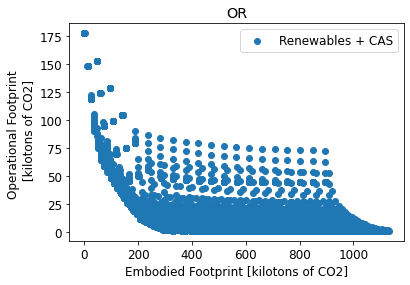

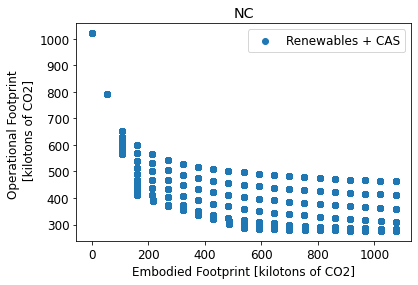

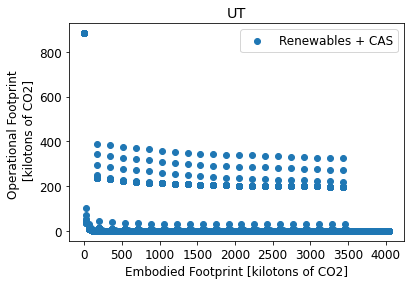

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from src.cas import *
import src.utils as utils

# store the final embodied and operational footprint numbers in this map
server_results_map_final = []
# Maximum allowed additional server capacity, % above current capacity
max_allowed_extra_cap = 100
# maximum renewable capacity to be evaluated
max_wind_range = 500
max_sol_range = 500
# % of flexible workloads at every hour
flexible_work_ratio = 40

for dc in dc_ba_map:
    ba = dc_ba_map[dc]
    d = extractDCRange(dc, START_DATE, END_DATE)
    cur_cap = d.max().item()
    avg_dc_pow = d.mean().item()

    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    db[db < 0] = 0
    wnd_db = db["WND"].fillna(0)
    sun_db = db["SUN"].fillna(0)
    max_wnd_cap = wnd_db.max()
    max_sun_cap = sun_db.max()
    #calculate avg carbon intensity of the grid
    carbon_intensity = calculateAVGCarbonIntensity(db)
    avg_carbon_intensity = carbon_intensity["carbon_intensity"].mean()

    d.index = pd.to_datetime(d.index).tz_localize("UTC")

    results_server = pd.DataFrame(
        columns=[
            "wnd_capacity",
            "sun_capacity",
            "extra_capacity",
            "balanced_coverage",
            "op_footprint",
            "emb_footprint",
        ]
    )

    max_wind_range += ba_ppa_map[ba][0]
    max_sol_range += ba_ppa_map[ba][1]
    # max capacity x% above current capacity
    for extra_capacity in range(0, max_allowed_extra_cap+1, 10):
        max_cap = cur_cap + cur_cap * extra_capacity / 100
        for wnd_capacity in range(0, max_wind_range, int(max_wind_range / 20)):
            for sun_capacity in range(0, max_sol_range, int(max_sol_range / 20)):
                SUN_PPA_MW = sun_capacity
                WND_PPA_MW = wnd_capacity
                # print("PPA Amount --  SUN: ", SUN_PPA_MW, "WND: ", WND_PPA_MW)
                wnd_db_scaled = wnd_db
                sun_db_scaled = sun_db
                if max_wnd_cap != 0:
                    wnd_db_scaled = wnd_db / max_wnd_cap * WND_PPA_MW
                if max_sun_cap != 0:
                    sun_db_scaled = sun_db / max_sun_cap * SUN_PPA_MW
                projected_db = pd.concat([wnd_db_scaled, sun_db_scaled], axis=1)
                sum_db = wnd_db_scaled + sun_db_scaled
                sum_db.rename("tot_renewable", inplace=True)
                # join dc & total renewable energy data frames
                df_all = d.join(sum_db)

                # apply cas algorithm from cas.py
                final_balanced_df = cas(df_all, flexible_work_ratio, max_cap)
                
                # calculate coverage
                balanced_coverage = utils.calculate_coverage(final_balanced_df["tot_renewable"], final_balanced_df["avg_dc_power_mw"])
   
                delta = int((datetime.strptime(END_DATE, "%Y-%m-%d") - datetime.strptime(START_DATE, "%Y-%m-%d")).days)
                tot_wind_energy = wnd_db_scaled.sum()/delta*10*365 # normalize to 10 years of operation
                tot_sun_energy = sun_db_scaled.sum()/delta*10*365 # normalize to 10 years of operation
                emb_footprint = avg_dc_pow*(extra_capacity/100) * (embodied_server_footprint / 1000) * (10 / server_lifetime) \
                    + (tot_sun_energy * embodied_solar_farm_footprint + tot_wind_energy * embodied_wind_farm_footprint) / (10**6)  # 10 years of time, kilotons of Co2

                results_server.loc[results_server.shape[0]] = [
                    wnd_capacity,
                    sun_capacity,
                    extra_capacity,
                    balanced_coverage,
                    (avg_dc_pow* ((100-balanced_coverage)/100) *10*365*24) * avg_carbon_intensity / (10**6), #10 years of duration, kilotons of Co2
                    emb_footprint,
                ]

    fig = plt.figure(figsize=(6, 4))
    plt.rcParams.update({"font.size": 12})
    ax = fig.gca()
    plt.title(ba)
    ax.scatter(
        results_server["emb_footprint"], results_server["op_footprint"], label="Renewables + CAS"
    )
    ax.set(xlabel="Embodied Footprint [kilotons of CO2]", ylabel="Operational Footprint \n [kilotons of CO2]")
    ax.set_title(dc)
    plt.legend()
    plt.show()
    server_results_map_final.append(pickle.loads(pickle.dumps(results_server)))

## 5.4. Combined Embodied and Operational Carbon Footprint Analysis for All Three Solutions

Plot embodied and operational footprint of all solutions together.

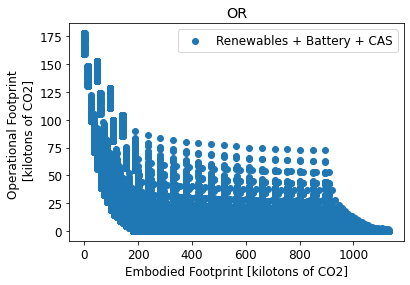

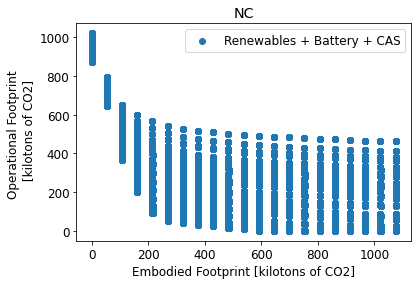

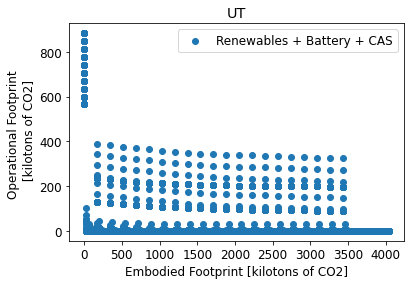

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from src.cas import *
import src.utils as utils

# store the final embodied and operational footprint numbers in this map
batteryandserver_results_map_final = []
# Maximum allowed additional server capacity, % above current capacity
max_allowed_extra_cap = 100
# maximum renewable capacity to be evaluated
max_wind_range = 500
max_sol_range = 500
# % of flexible workloads at every hour
flexible_work_ratio = 40
# maximum battery capacity to be evaluated
max_bat_range = 1000 #mwh

for dc in dc_ba_map:
    ba = dc_ba_map[dc]
    d = extractDCRange(dc, START_DATE, END_DATE)
    cur_cap = d.max().item()
    avg_dc_pow = d.mean().item()

    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    db[db < 0] = 0
    wnd_db = db["WND"].fillna(0)
    sun_db = db["SUN"].fillna(0)
    max_wnd_cap = wnd_db.max()
    max_sun_cap = sun_db.max()
    #calculate avg carbon intensity of the grid
    carbon_intensity = calculateAVGCarbonIntensity(db)
    avg_carbon_intensity = carbon_intensity["carbon_intensity"].mean()

    d.index = pd.to_datetime(d.index).tz_localize("UTC")

    results_server = pd.DataFrame(
        columns=[
            "wnd_capacity",
            "sun_capacity",
            "extra_capacity",
            "battery_capacity",
            "balanced_coverage",
            "op_footprint",
            "emb_footprint",
        ]
    )

    max_wind_range += ba_ppa_map[ba][0]
    max_sol_range += ba_ppa_map[ba][1]

    for battery_cap in range(0, max_bat_range, 100):
        for extra_capacity in range(0, max_allowed_extra_cap+1, 10):
            max_cap = cur_cap + cur_cap * extra_capacity / 100
            for wnd_capacity in range(0, max_wind_range, int(max_wind_range / 20)):
                for sun_capacity in range(0, max_sol_range, int(max_sol_range / 20)):
                    SUN_PPA_MW = sun_capacity
                    WND_PPA_MW = wnd_capacity
                    # print("PPA Amount --  SUN: ", SUN_PPA_MW, "WND: ", WND_PPA_MW)
                    wnd_db_scaled = wnd_db
                    sun_db_scaled = sun_db
                    if max_wnd_cap != 0:
                        wnd_db_scaled = wnd_db / max_wnd_cap * WND_PPA_MW
                    if max_sun_cap != 0:
                        sun_db_scaled = sun_db / max_sun_cap * SUN_PPA_MW
                    projected_db = pd.concat([wnd_db_scaled, sun_db_scaled], axis=1)
                    ren_mw = wnd_db_scaled + sun_db_scaled

                    # apply battery analysis
                    tot_non_ren_mw, ren_mw_with_battery = bat.apply_battery(battery_cap, ren_mw, d)                
                    ren_mw_with_battery.rename("tot_renewable", inplace=True)

                    # join dc & total renewable energy data frames
                    df_all = d.join(ren_mw_with_battery)

                    # apply cas algorithm from cas.py
                    final_balanced_df = cas(df_all, flexible_work_ratio, max_cap)
                    
                    # calculate coverage
                    balanced_coverage = utils.calculate_coverage(final_balanced_df["tot_renewable"], final_balanced_df["avg_dc_power_mw"])
                    
                    delta = int((datetime.strptime(END_DATE, "%Y-%m-%d") - datetime.strptime(START_DATE, "%Y-%m-%d")).days)
                    tot_wind_energy = wnd_db_scaled.sum()/delta*10*365 # normalize to 10 years of operation
                    tot_sun_energy = sun_db_scaled.sum()/delta*10*365 # normalize to 10 years of operation
                    emb_footprint = avg_dc_pow*(extra_capacity/100) * (embodied_server_footprint / 1000) * (10 / server_lifetime) \
                        + (tot_sun_energy * embodied_solar_farm_footprint + tot_wind_energy * embodied_wind_farm_footprint) / (10**6)  # 10 years of time, kilotons of Co2

                    results_server.loc[results_server.shape[0]] = [
                        wnd_capacity,
                        sun_capacity,
                        extra_capacity,
                        battery_cap,
                        balanced_coverage,
                        (avg_dc_pow* ((100-balanced_coverage)/100) *10*365*24) * avg_carbon_intensity / (10**6), #10 years of duration, kilotons of Co2
                        emb_footprint,
                    ]

    fig = plt.figure(figsize=(6, 4))
    plt.rcParams.update({"font.size": 12})
    ax = fig.gca()
    plt.title(ba)
    ax.scatter(
        results_server["emb_footprint"], results_server["op_footprint"], label="Renewables + Battery + CAS"
    )
    ax.set(xlabel="Embodied Footprint [kilotons of CO2]", ylabel="Operational Footprint \n [kilotons of CO2]")
    ax.set_title(dc)
    plt.legend()
    plt.show()
    batteryandserver_results_map_final.append(pickle.loads(pickle.dumps(results_server)))

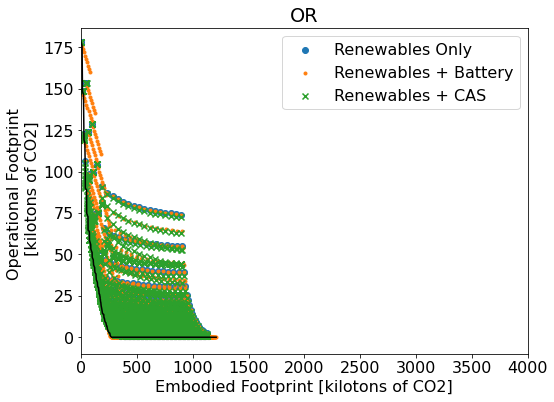

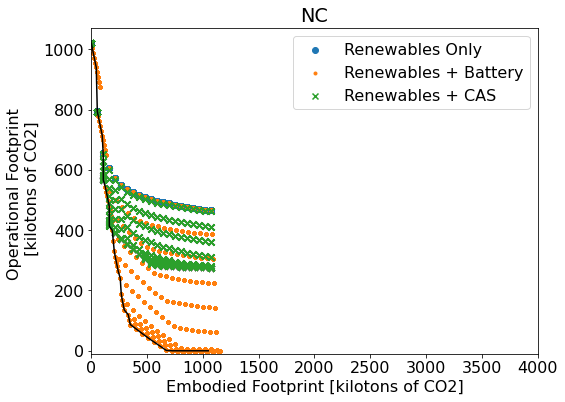

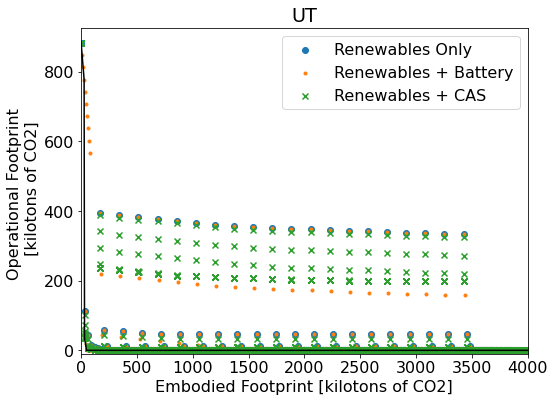

In [33]:
import numpy as np
import seaborn as sns
from matplotlib.collections import LineCollection
from src.utils import *

ba_id = 0
for dc in dc_ba_map:
    fig = plt.figure(figsize=(8, 6))
    plt.rcParams.update({"font.size": 16})
    ax = plt.gca()
    results_ren = ren_results_map_final[ba_id]
    results_bat = battery_results_map_final[ba_id]
    results_server = server_results_map_final[ba_id]
    if(ba in ["SOCO", "DUK", "TVA"]):
        results_ren_fin = results_ren[results_ren["wnd_capacity"]==0]
        results_bat_fin = results_bat[results_bat["wnd_capacity"]==0]
        results_server_fin = results_server[results_server["wnd_capacity"]==0]
    else:
        results_ren_fin = results_ren
        results_bat_fin = results_bat
        results_server_fin = results_server
    #scatter plot
    ax.scatter(
        results_ren_fin["emb_footprint"],
        results_ren_fin["op_footprint"],
        label="Renewables Only",
        marker='o'
    )
    # battery
    ax.scatter(
        results_bat_fin["emb_footprint"],
        results_bat_fin["op_footprint"],
        label="Renewables + Battery",
        marker='.'
    )
    #cas
    ax.scatter(
        results_server_fin["emb_footprint"],
        results_server_fin["op_footprint"],
        label="Renewables + CAS",
        marker='x'
    )
    #ax.set_yscale('log')
    ba_id = ba_id + 1
    tot_ren_cap = ba_ppa_map[ba][0] + ba_ppa_map[ba][1]

    frames = (results_ren_fin[["emb_footprint", "op_footprint"]].append(results_bat_fin[["emb_footprint", "op_footprint"]])).append(results_server_fin[["emb_footprint", "op_footprint"]])
    p_front = pareto_frontier(frames["emb_footprint"].values.tolist(), frames["op_footprint"].values.tolist(), maxX = False, maxY = False)
    plt.plot(p_front[0], p_front[1], color="black")
    plt.xlim(0,4000)
    plt.title(dc)
    ax.set(xlabel="Embodied Footprint [kilotons of CO2]", ylabel="Operational Footprint \n [kilotons of CO2]")
    ax.set_ylim(bottom=-10)
    plt.legend()
    plt.show()

## 5.5. Carbon Optimal Solution to Minimize Total Footprint
Quantify the carbon footprint reduction effectiveness across three strategies by finding the carbon-optimal point from each solution and comparing them.

TOTAL CARBON FOOTPRINT ANALYSIS RESULTS

OR datacenter: 
	 1. Renewable-Only Carbon Optimal Point:
		 Renewable coverage: 47.40%.
		 Solar, wind capacity: 0.0 MW, 200.0 MW.
	 2. Renewable+Battery Carbon Optimal Point:
		 Renewable coverage: 47.40%.
		 Solar, wind capacity: 0.0 MW, 200.0 MW.
		 Battery capacity: 0.0 MWh.
	 3. Renewable+CAS Carbon Optimal Point:
		 Renewable coverage: 57.96%.
		 Solar, wind capacity: 0.0 MW, 200.0 MW.
		 Additional server capacity: 100.0%.
	 4. Renewable+Battery+CAS Carbon Optimal Point:
		 Renewable coverage: 78.15%.
		 Solar, wind capacity: 0.0 MW, 250.0 MW.
		 Additional server capacity: 0.0%.
		 Battery capacity: 900.0 MWh.

NC datacenter: 
	 1. Renewable-Only Carbon Optimal Point:
		 Renewable coverage: 35.76%.
		 Solar, wind capacity: 90.0 MW, 0.0 MW.
	 2. Renewable+Battery Carbon Optimal Point:
		 Renewable coverage: 86.72%.
		 Solar, wind capacity: 180.0 MW, 0.0 MW.
		 Battery capacity: 900.0 MWh.
	 3. Renewable+CAS Carbon Optimal Point:
		 Renew

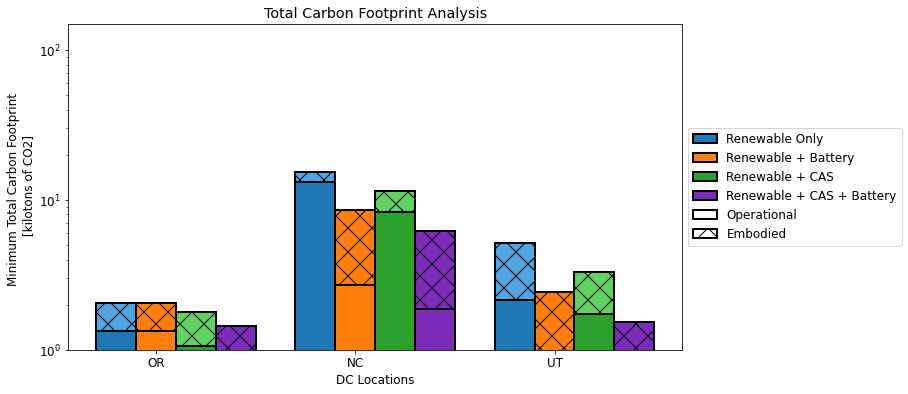

In [53]:
emb_min_ren_footprint = []
emb_min_bat_footprint = []
emb_min_server_footprint = []
emb_min_bat_server_footprint = []
op_min_ren_footprint = []
op_min_bat_footprint = []
op_min_server_footprint = []
op_min_bat_server_footprint = []
ba_id = 0
NORMALIZE_PER_MW = True

print("TOTAL CARBON FOOTPRINT ANALYSIS RESULTS")

for dc in dc_ba_map:
    print('\033[1m' + "\n" + dc + " datacenter: "+ '\033[0m')
    results_ren = ren_results_map_final[ba_id]
    results_bat = battery_results_map_final[ba_id]
    results_server = server_results_map_final[ba_id]
    results_bat_server = batteryandserver_results_map_final[ba_id]
    results_ren_sum = results_ren["emb_footprint"] + results_ren["op_footprint"]
    min_idx = results_ren_sum.idxmin()
    
    d = extractDCRange(dc, START_DATE, END_DATE)
    avg_dc_pow = d.mean().item()
    
    if NORMALIZE_PER_MW:
        emb_min_ren_footprint.append(results_ren.at[min_idx, "emb_footprint"] / avg_dc_pow)
        op_min_ren_footprint.append(results_ren.at[min_idx, "op_footprint"] / avg_dc_pow)
    else:
        emb_min_ren_footprint.append(results_ren.at[min_idx,'emb_footprint'])
        op_min_ren_footprint.append(results_ren.at[min_idx,'op_footprint'])
    print('\033[1m' + "\t 1. Renewable-Only Carbon Optimal Point:"+ '\033[0m') 
    print("\t\t Renewable coverage: {:0.2f}%.".format(results_ren.at[min_idx,'coverage']))
    print("\t\t Solar, wind capacity: {} MW, {} MW.".format(results_ren.at[min_idx,'sun_capacity'],results_ren.at[min_idx,'wnd_capacity']))

    results_bat_sum = results_bat["emb_footprint"] + results_bat["op_footprint"]
    min_idx = results_bat_sum.idxmin()
    if NORMALIZE_PER_MW:
        emb_min_bat_footprint.append(results_bat.at[min_idx, "emb_footprint"] / avg_dc_pow)
        op_min_bat_footprint.append(results_bat.at[min_idx, "op_footprint"] / avg_dc_pow)
    else:
        emb_min_bat_footprint.append(results_bat.at[min_idx,'emb_footprint'])
        op_min_bat_footprint.append(results_bat.at[min_idx,'op_footprint'])
    print('\033[1m' + "\t 2. Renewable+Battery Carbon Optimal Point:"+ '\033[0m') 
    print("\t\t Renewable coverage: {:0.2f}%.".format(results_bat.at[min_idx,'coverage']))
    print("\t\t Solar, wind capacity: {} MW, {} MW.".format(results_bat.at[min_idx,'sun_capacity'], results_bat.at[min_idx,'wnd_capacity']))
    print("\t\t Battery capacity: {} MWh.".format(results_bat.at[min_idx,'battery_capacity']))

    results_server_sum = results_server["emb_footprint"] + results_server["op_footprint"]
    min_idx = results_server_sum.idxmin()
    if NORMALIZE_PER_MW:
        emb_min_server_footprint.append(results_server.at[min_idx, "emb_footprint"] / avg_dc_pow)
        op_min_server_footprint.append(results_server.at[min_idx, "op_footprint"] / avg_dc_pow)
    else:
        emb_min_server_footprint.append(results_server.at[min_idx,'emb_footprint'])
        op_min_server_footprint.append(results_server.at[min_idx,'op_footprint'])
    print('\033[1m' + "\t 3. Renewable+CAS Carbon Optimal Point:"+ '\033[0m')  
    print("\t\t Renewable coverage: {:0.2f}%.".format(results_server.at[min_idx,'balanced_coverage']))
    print("\t\t Solar, wind capacity: {} MW, {} MW.".format(results_server.at[min_idx,'sun_capacity'], results_server.at[min_idx,'wnd_capacity']))
    print("\t\t Additional server capacity: {}%.".format(results_server.at[min_idx,'extra_capacity']))

    results_bat_server_sum = results_bat_server["emb_footprint"] + results_bat_server["op_footprint"]
    min_idx = results_bat_server_sum.idxmin()
    if NORMALIZE_PER_MW:
        emb_min_bat_server_footprint.append(results_bat_server.at[min_idx, "emb_footprint"] / avg_dc_pow)
        op_min_bat_server_footprint.append(results_bat_server.at[min_idx, "op_footprint"] / avg_dc_pow)
    else:
        emb_min_bat_server_footprint.append(results_bat_server.at[min_idx, "emb_footprint"])
        op_min_bat_server_footprint.append(results_bat_server.at[min_idx, "op_footprint"])
    print("\033[1m" + "\t 4. Renewable+Battery+CAS Carbon Optimal Point:" + "\033[0m")
    print("\t\t Renewable coverage: {:0.2f}%.".format(results_bat_server.at[min_idx, "balanced_coverage"]))
    print("\t\t Solar, wind capacity: {} MW, {} MW.".format(results_bat_server.at[min_idx, "sun_capacity"], results_bat_server.at[min_idx, "wnd_capacity"]))
    print("\t\t Additional server capacity: {}%.".format(results_bat_server.at[min_idx, "extra_capacity"]))
    print("\t\t Battery capacity: {} MWh.".format(results_bat_server.at[min_idx, "battery_capacity"]))
    
    ba_id += 1
    plt.show()

# plot data as a grouped bar chart
fig = plt.figure(figsize=(11, 6))
x = np.arange(len(dc_ba_map))
width = 0.2
plt.xticks(x, dc_ba_map)
plt.xlabel("DC Locations")
plt.ylabel("Minimum Total Carbon Footprint \n [kilotons of CO2]")
plt.bar(x-width, op_min_ren_footprint, width, label="Renewable Only", color="#1f77b4", edgecolor = 'black', linewidth=2)
plt.bar(x-width, emb_min_ren_footprint, width, bottom=op_min_ren_footprint, color = "#51a5e1", hatch="x", edgecolor = 'black', linewidth=2)

plt.bar(x, op_min_bat_footprint, width, label="Renewable + Battery", color="#ff7f0e",  edgecolor = 'black', linewidth=2)
plt.bar(x, emb_min_bat_footprint, width,bottom=op_min_bat_footprint, color="#ff7f0e", hatch="x",  edgecolor = 'black',  linewidth=2)

plt.bar(x+width, op_min_server_footprint, width, label = "Renewable + CAS", color="#2ca02c",  edgecolor = 'black',  linewidth=2)
plt.bar(x+width, emb_min_server_footprint, width, bottom=op_min_server_footprint, color = "#5fd35f", hatch="x",  edgecolor = 'black',  linewidth=2)

plt.bar(x+2*width, op_min_bat_server_footprint, width, label = "Renewable + CAS + Battery", color="#7B2DB9",  edgecolor = 'black',  linewidth=2)
plt.bar(x+2*width, emb_min_bat_server_footprint, width, bottom=op_min_bat_server_footprint, color = "#7B2DB9", hatch="x",  edgecolor = 'black',  linewidth=2)

plt.bar(x+width, ([0]*len(dc_ba_map)), width, label = "Operational", color="#ffffff",  edgecolor = 'black',  linewidth=2)
plt.bar(x+width, ([0]*len(dc_ba_map)), width, label = "Embodied", color = "#ffffff", hatch="x",  edgecolor = 'black',  linewidth=2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = plt.gca()
ax.set_yscale('log')
ax.set_ylim(bottom=1, top=150)
ax.tick_params(axis='x', which='minor', bottom=False)
plt.title("Total Carbon Footprint Analysis")
plt.show()